In [1]:
# Import Pandas
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# Reading and creating directories
import os

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

# Progress bar

from tqdm import tqdm

# Reload modules
%load_ext autoreload
%autoreload 2

# Import Statsbombpy to load StatsBomb360
from statsbombpy import sb
# Import Socceraction modules to load and manipulate StatsBomb open data
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat

In [496]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects  
from mplsoccer.pitch import VerticalPitch
import seaborn as sns
import mplsoccer.pitch
import os
import sys
import bz2
import pickle
from scipy.spatial import ConvexHull
from scipy.interpolate import interp2d
from scipy.spatial import Delaunay
from shapely.geometry.polygon import Polygon
from mplsoccer import PyPizza, add_image, FontManager

In [3]:
# Data Visualization libraries
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects  
from mplsoccer.pitch import VerticalPitch
import seaborn as sns
import mplsoccer.pitch
import os
import sys
import bz2
import pickle
from scipy.spatial import ConvexHull
from scipy.interpolate import interp2d
from scipy.spatial import Delaunay
from shapely.geometry.polygon import Polygon
from scipy import stats

from PIL import Image, ImageEnhance
import requests
from io import BytesIO

from urllib.request import urlopen
import matplotlib.cm as cm
import io
import math
from mplsoccer import Sbopen, Pitch

In [4]:
import tqdm

In [2]:
# Initiate the loader
SBL = StatsBombLoader()

games = SBL.games(competition_id=43, season_id=106)
games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...
59,3857265,106,43,Group Stage,1,2022-11-22 18:00:00,794,789,0,0,Stadium 974,Chris Beath
60,3857262,106,43,Group Stage,3,2022-12-02 17:00:00,791,780,2,1,Education City Stadium,Facundo Tello Figueroa
61,3857261,106,43,Group Stage,3,2022-11-29 21:00:00,907,768,0,3,Ahmad bin Ali Stadium,Slavko Vinčić
62,3857255,106,43,Group Stage,3,2022-12-01 21:00:00,778,772,2,1,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes


In [5]:
# Create progress bar and iterator
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")

# Lists and dictionaries to store information
teams, players= [], []
events, actions, frames = {},{},{}

# Iterate over games
for game in games_verbose:
    # load data (game.game_id provides the id of each match)
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events[game.game_id] = SBL.events(game.game_id)
    frames[game.game_id] = sb.frames(match_id = game.game_id, fmt='dataframe')
    
    # Convert data to spadl 
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events[game.game_id], game.home_team_id)
    actions[game.game_id] = spadl.add_names(actions[game.game_id])
    
    # Add xT value to each action
    url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
    xT_model = xthreat.load_model(url_grid)
    df_actions_ltr = spadl.play_left_to_right(actions[game.game_id], game.home_team_id)
    xT_list = xT_model.rate(df_actions_ltr)
    xT_list = [round(num,3) for num in xT_list]
    actions[game.game_id]['xT'] = xT_list
    
    # Add supplementary information to each action that aren't include in the SPADL format
    df_additional = events[game.game_id][['event_id','under_pressure','duration']]
    actions[game.game_id] = actions[game.game_id].merge(df_additional, left_on = 'original_event_id', right_on = 'event_id')
    actions[game.game_id].drop('event_id',axis = 1, inplace = True)
    
    # Split Location in the SB360 datafram and convert to a 105 m x 68 m  pitch
    frames[game.game_id]['loc_x'] = frames[game.game_id].location.apply(lambda x: x[0] if x else 1).clip(1, 120)
    frames[game.game_id]['loc_y'] = frames[game.game_id].location.apply(lambda x: x[1] if x else 1).clip(1, 80)
    frames[game.game_id]['loc_x'] = ((frames[game.game_id]['loc_x'] - 1) / 119) * 105
    frames[game.game_id]['loc_y'] = 68 - ((frames[game.game_id]['loc_y'] - 1) / 79) * 68

# Create teams and players dataframe    
teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

# Choose the folder's path
datafolder = "WorldCup2022"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

worldCup2022 = os.path.join(datafolder, "worldCup2022.h5")

# Store all data in h5-file
with pd.HDFStore(worldCup2022) as spadlstore:
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'minutes_played','starting_position_name']]
    
    for game_id in actions.keys():
        spadlstore[f"events/game_{game_id}"] = events[game_id]
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        spadlstore[f"frames/game_{game_id}"] = frames[game_id]

Loading game data: 100%|███████████████████████████████████████████████████████████████| 64/64 [05:36<00:00,  5.26s/it]


In [6]:
def line_breaking_df(df, frames):
    """
    Function that returns a dataframe in the extended SPADL format with a new column that specifies if the action is 
    a line breaking pass. 
    It is recommended to ensure a good execution time that the dataframe df in input contains only passes. 
    
    
    Parameters
    ----------
    df: pd.DataFrame
        dataframe of a given match in the SPADL format
    
    frames: pd.DataFrame
        dataframe that cointains StatsBomb360 data
        
        
    Returns
    -------
    df: pd.DataFrame
        uptated version of the dataframe df given as input with a new column that specifies if the pass is line breaking.
        
    """
    
    # Define a function that identifies line breaking passes
    def row_line_breaking(row):
        """
        It returns if the pass is classified as line breaking or not. If the row given in input does 
        not describe a pass the function returns Nan. It must be applied to a dataframe 
        that contains match event data in the SPADL format, which has also to be associated with 
        a StatsBomb360 frames datataframe. 

        Match-event dataframe: df
        StatsBomb360 frames datataframe: frames

        Parameters
        ----------
        row: pd.Series 
                row that describes a single event/action in the SPADL format. 
                Preferably, the event should be a pass.  


        Returns
        -------
        boolean or NaN
            True if the pass is identified as a line breaking one. False is the pass is not line breaking. 
            NaN if the event is not a pass.
        """
        
        # Import jenkspy to perform 1-D clustering
        from jenkspy import JenksNaturalBreaks
        
        # Library for computing if two line segments intersect
        from shapely.geometry import LineString

        # Check if the action is a pass
        if row['type_name'] != 'pass':

            # If the actions is not a pass, return NaN
            return np.nan

        # If the action is a pass, start the algorithm
        else:

            # Create a 1-row dataframe from df that contains only the pass 
            df_pass = df.loc[row.name: row.name].copy()
            
            # Check first condition: the pass must advance the ball of at least 10 m
            if float(df_pass.end_x) >= float(df_pass.start_x) + 10:
                
                # Merge df_pass with the corresponding event in the SB360 frames
                df_360 = df_pass.merge(frames, how = 'left', left_on = 'original_event_id', right_on = 'id' ).copy()
                
                # Exclude passer's teammates
                df_360_opp = df_360[df_360.teammate == False].copy()
                
                # Exclude the goalkeeper
                df_360_opp = df_360_opp[df_360_opp.keeper == False]
                
                # Check if there are at least 2 defenders 
                if len(df_360_opp) >=2:

                    # The defensive lines, the ones that we want to check if they're broken by the pass,
                    # will be identified with a 1-D clustering on the x-dimension of the pitch. 
                    # 1-D Clustering = Fisher-Jenks algorithm

                    # Find the x-values
                    x = list(df_360_opp.loc_x)

                    # If the number of values (i.e. the number of defenders in the 360-frames) are more than 4
                    # find 3 defensive lines
                    if len(x)>4:

                        # Create the model for 3 clusters
                        jnb = JenksNaturalBreaks(3)

                        # Fit the model
                        jnb.fit(x)

                        # Predict the cluster (i.e. line)
                        df_360_opp['group'] = jnb.labels_
                    
                    # If the number of defenders is 4, consider 2 clusters.
                    elif len(x)>3:
                        
                        # Create the model for 2 clusters, fit and label the values
                        jnb = JenksNaturalBreaks(2)
                        jnb.fit(x)
                        df_360_opp['group'] = jnb.labels_
                   
                    # If there are 2 or 3 defenders in the frames, label all the defenders in the same group
                    else:
                        df_360_opp['group'] = 0
                    
                        # If there are 2 or 3 defenders we want to be sure that they are close
                        # to each other in the x-direction since we label them in the same
                        # Create a function that computes the distance between players
                        def dx(row):
                            k = list(df_360_opp.loc_x)
                            ind = k.index(float(row['loc_x']))
                            z = k[:ind] + k[ind+1:]
                            return min([abs(w-k[ind]) for w in z ])
                        df_360_opp['dx'] = df_360_opp.apply(dx, axis = 1)
                        
                        # Exclude defenders that are more than 8 m (arbitrary) distant to the closest teammate
                        df_360_opp = df_360_opp[df_360_opp.dx <= 8].copy()
                    
                    # Create dataframes for each group and order them in the y-direction 
                    # This order ensures that we have "vertical" lines. 
                    df_0 = df_360_opp[(df_360_opp.group == 0)].sort_values('loc_y', ascending = False).copy()
                    df_0.reset_index(inplace = True)
                    df_1 = df_360_opp[(df_360_opp.group == 1)].sort_values('loc_y', ascending = False).copy()
                    df_1.reset_index(inplace = True)
                    df_2 = df_360_opp[(df_360_opp.group == 2)].sort_values('loc_y', ascending = False).copy()
                    df_2.reset_index(inplace = True)

                    # Create the pass segment with LineString  
                    line = LineString([(df_pass.start_x,df_pass.start_y),(df_pass.end_x,df_pass.end_y)])
                      # Compute if the pass segment intersect with the defender lines segment 
                    # If yes, then the pass is identifies as line breaking
                    # For each group: 
                    # - iterate over the defenders
                    # - check if the defenders are at most 15 m (arbitrary) distant in the y-direction
                    # - Create the defender segment and check the intersection, return True if so
                    i = 0
                    while i < len(df_0)-1:
                        if abs(df_0.iloc[i].loc_y-df_0.iloc[i+1].loc_y) <= 15:
                            other = LineString([(df_0.iloc[i].loc_x,df_0.iloc[i].loc_y),
                                                (df_0.iloc[i+1].loc_x,df_0.iloc[i+1].loc_y)])
                            if line.intersects(other) == True:
                                return True
                        i+=1

                    i = 0
                    while i < len(df_1)-1:
                        if abs(df_1.iloc[i].loc_y-df_1.iloc[i+1].loc_y) <= 15:
                            other = LineString([(df_1.iloc[i].loc_x,df_1.iloc[i].loc_y),
                                                (df_1.iloc[i+1].loc_x,df_1.iloc[i+1].loc_y)])
                            if line.intersects(other) == True:
                                return True
                        i+=1

                    i=0
                    while i < len(df_2)-1:
                        if abs(df_2.iloc[i].loc_y-df_2.iloc[i+1].loc_y) <= 15:
                            other = LineString([(df_2.iloc[i].loc_x,df_2.iloc[i].loc_y),
                                                (df_2.iloc[i+1].loc_x,df_2.iloc[i+1].loc_y)])
                            if line.intersects(other) == True:
                                return True
                        i+=1
                    
                    # Return False if the pass does not break any line 
                    return False
                
                # This actives if there are 0 or 1 defenders in the 360-frame.
                return False
                
            # This activates if the pass does not advance the ball of at least 10 m. 
            else:
                
                # If the pass does not move the ball 10 m forward, return False
                return False
    
    
    
    # Apply row_line_breaking to create a new column that specifies if the pass is line breaking
    df['line_breaking'] = df.apply(row_line_breaking, axis = 1)
    
    # Return the updated dataframe
    return df

In [157]:
# Load data
datafolder = r"WorldCup2022"
spadl_h5 = os.path.join(datafolder, "worldCup2022.h5")

# Import time to count the execution time
import time
st = time.time()

# Open data
with pd.HDFStore(spadl_h5) as spadlstore:
    
    # Get all games of worldcup2022
    games = (
        spadlstore["games"]
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    
    # Create a dataframe to store the data about all passes of Euro2020
    all_passes = pd.DataFrame()
    
    # Iterate over each national team
    for squad in set(games.home_team_name.unique()):
        
        # Select all games of squad
        squad_games = games[(games.home_team_name == squad) | (games.away_team_name == squad)]
        
        # Iterate over all games of squad
        for a, game in  tqdm(list(squad_games.iterrows())):
            
            # Get game_id 
            game_id = game.game_id
            
            # Get the event-data dataframe in the extended SPADL format for the game
            actions = (
                spadlstore[f"actions/game_{game_id}"]
                .merge(spadl.actiontypes_df(), how="left")
                .merge(spadl.results_df(), how="left")
                .merge(spadl.bodyparts_df(), how="left")
                .merge(spadlstore["players"], how="left")
               .merge(spadlstore["teams"], how="left")
            )
            
            # Add information about which player is in the next action.
            # This could be useful for analyses about which players receive more line breaking passes
            actions['next_player'] = actions.player_name.shift(-1)
            actions['next_action'] = actions.type_name.shift(-1)
            actions['second_next_action'] = actions.type_name.shift(-2)
            actions['Third_next_action'] = actions.type_name.shift(-3)
            actions['next_action_result'] = actions['result_name'].shift(-1)
            actions['second_next_action_result'] = actions['result_name'].shift(-2)
            actions['Third_next_action_result'] = actions['result_name'].shift(-3)
            
            # Make both teams attack from left to right
            actions = spadl.play_left_to_right(actions, game.squeeze()['home_team_id'])
            
            # Get StatsBomb360 frames dataframe of the game
            frames = spadlstore[f"frames/game_{game_id}"]
            
            # Select only passes
            passes = actions[(actions.type_name == 'pass') | (actions.type_name == 'cross')  | (actions.type_name == 'freekick_crossed')  | (actions.type_name == 'corner_crossed')].copy()
            
            # Apply line_breaking_df to understand which passes are breaking line passes
            passes = line_breaking_df(passes, frames)
            
            # Update the dataframe that contain only passes 
            all_passes = pd.concat([all_passes, passes])
            

# Estimate execution time       
et = time.time()
elapsed_time = round((et - st)/60,2)
print('Execution time:', elapsed_time, 'minutes')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.05s/it]


Execution time: 9.77 minutes


In [158]:
def is_progressive(start_x, start_y, end_x, end_y):
    start_dist = np.sqrt((105 - start_x)**2 + (34 - start_y)**2)
    end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2)
    #mark that passes to own half are not progressive
    thres = 100
    if start_x < 52.5 and end_x < 52.5:
        thres = 30
    elif start_x < 52.5 and end_x >= 52.5:
        thres = 15
    elif start_x >= 52.5 and end_x > 52.5:
        thres = 10
    if thres > start_dist - end_dist:
        return False
    else:
        return True

all_passes["is_progressive"] = all_passes.apply(lambda row : is_progressive(row['start_x'], row['start_y'], row['end_x'], row['end_y']), axis = 1)
all_passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive
0,3857282,72de3800-f335-49f0-bdb2-1d102fe07d5d,1,0.0,1839,22168.0,52.058824,34.430380,33.352941,37.443038,0,1,5,0,pass,success,foot_right,-0.004,False,1.392206,Joshua Sargent,United States,Tim Ream,dribble,pass,clearance,success,fail,success,False,False
2,3857282,70e81e4e-523f-4d32-9fae-88e17a2b2202,1,3.0,1839,18242.0,33.705882,38.562025,86.205882,19.194937,0,0,4,2,pass,fail,foot_left,NaN,False,2.951226,Tim Ream,United States,Ben Davies,clearance,pass,dribble,success,success,success,True,True
4,3857282,60768852-6ed0-4cc8-a486-c121cdb9517f,1,8.0,907,9540.0,20.294118,63.007595,44.647059,62.060759,0,1,4,4,pass,success,foot_left,0.004,False,2.081870,Harry Wilson,Wales,Daniel James,dribble,bad_touch,throw_in,success,fail,success,False,False
9,3857282,86ed29a7-aa61-4376-9c81-9bc58b3b521d,1,16.0,1839,18242.0,38.029412,16.956962,48.441176,54.227848,0,1,5,9,pass,success,foot_right,0.002,False,2.577206,Tim Ream,United States,Antonee Robinson,dribble,pass,dribble,success,success,success,False,False
11,3857282,84c2d984-5fc2-45e9-90f8-d9cd5a6d6175,1,22.0,1839,4614.0,55.411765,58.445570,48.970588,46.997468,0,1,4,11,pass,success,foot_left,-0.002,False,1.424170,Antonee Robinson,United States,Yunus Dimoara Musah,dribble,pass,dribble,success,success,success,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,3857293,c6ca3792-1590-4ba3-9cce-795e4a6ff589,2,3166.0,783,7104.0,33.176471,26.167089,44.117647,22.551899,0,1,4,1981,pass,success,foot_left,0.003,True,1.036285,Mathías Olivera Miramontes,Uruguay,Matías Vecino Falero,dribble,pass,dribble,success,success,success,True,False
1914,3857293,699c76e2-b9c6-4226-bac2-5ff062991ed3,2,3169.0,783,5255.0,45.000000,22.724051,44.823529,7.402532,0,1,5,1983,pass,success,foot_right,-0.002,False,1.089145,Matías Vecino Falero,Uruguay,Guillermo Varela Olivera,dribble,pass,dribble,success,fail,success,False,False
1916,3857293,f3bfb436-ad86-4c0d-880e-59d60dbe103a,2,3170.0,783,5264.0,44.823529,7.402532,97.147059,35.635443,0,0,5,1985,pass,fail,foot_right,NaN,False,4.459381,Guillermo Varela Olivera,Uruguay,Lawrence Ati-Zigi,dribble,pass,dribble,success,success,success,False,True
1918,3857293,93a2f5c6-ba56-41a2-bdd3-2ebba9b97c72,2,3177.0,4885,8108.0,10.676471,30.987342,59.558824,4.820253,0,1,0,1987,pass,success,foot,0.004,False,3.617211,Lawrence Ati-Zigi,Ghana,Abdul Fatawu Issahaku,dribble,take_on,tackle,success,fail,fail,True,True


In [159]:
all_passes['IntoFinalThird'] = np.where ((all_passes['start_x'] < 70) & (all_passes['end_x'] >= 70), True, False)
all_passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird
0,3857282,72de3800-f335-49f0-bdb2-1d102fe07d5d,1,0.0,1839,22168.0,52.058824,34.430380,33.352941,37.443038,0,1,5,0,pass,success,foot_right,-0.004,False,1.392206,Joshua Sargent,United States,Tim Ream,dribble,pass,clearance,success,fail,success,False,False,False
2,3857282,70e81e4e-523f-4d32-9fae-88e17a2b2202,1,3.0,1839,18242.0,33.705882,38.562025,86.205882,19.194937,0,0,4,2,pass,fail,foot_left,NaN,False,2.951226,Tim Ream,United States,Ben Davies,clearance,pass,dribble,success,success,success,True,True,True
4,3857282,60768852-6ed0-4cc8-a486-c121cdb9517f,1,8.0,907,9540.0,20.294118,63.007595,44.647059,62.060759,0,1,4,4,pass,success,foot_left,0.004,False,2.081870,Harry Wilson,Wales,Daniel James,dribble,bad_touch,throw_in,success,fail,success,False,False,False
9,3857282,86ed29a7-aa61-4376-9c81-9bc58b3b521d,1,16.0,1839,18242.0,38.029412,16.956962,48.441176,54.227848,0,1,5,9,pass,success,foot_right,0.002,False,2.577206,Tim Ream,United States,Antonee Robinson,dribble,pass,dribble,success,success,success,False,False,False
11,3857282,84c2d984-5fc2-45e9-90f8-d9cd5a6d6175,1,22.0,1839,4614.0,55.411765,58.445570,48.970588,46.997468,0,1,4,11,pass,success,foot_left,-0.002,False,1.424170,Antonee Robinson,United States,Yunus Dimoara Musah,dribble,pass,dribble,success,success,success,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,3857293,c6ca3792-1590-4ba3-9cce-795e4a6ff589,2,3166.0,783,7104.0,33.176471,26.167089,44.117647,22.551899,0,1,4,1981,pass,success,foot_left,0.003,True,1.036285,Mathías Olivera Miramontes,Uruguay,Matías Vecino Falero,dribble,pass,dribble,success,success,success,True,False,False
1914,3857293,699c76e2-b9c6-4226-bac2-5ff062991ed3,2,3169.0,783,5255.0,45.000000,22.724051,44.823529,7.402532,0,1,5,1983,pass,success,foot_right,-0.002,False,1.089145,Matías Vecino Falero,Uruguay,Guillermo Varela Olivera,dribble,pass,dribble,success,fail,success,False,False,False
1916,3857293,f3bfb436-ad86-4c0d-880e-59d60dbe103a,2,3170.0,783,5264.0,44.823529,7.402532,97.147059,35.635443,0,0,5,1985,pass,fail,foot_right,NaN,False,4.459381,Guillermo Varela Olivera,Uruguay,Lawrence Ati-Zigi,dribble,pass,dribble,success,success,success,False,True,True
1918,3857293,93a2f5c6-ba56-41a2-bdd3-2ebba9b97c72,2,3177.0,4885,8108.0,10.676471,30.987342,59.558824,4.820253,0,1,0,1987,pass,success,foot,0.004,False,3.617211,Lawrence Ati-Zigi,Ghana,Abdul Fatawu Issahaku,dribble,take_on,tackle,success,fail,fail,True,True,False


In [160]:
all_passes = all_passes.drop_duplicates(subset = 'original_event_id')
all_passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird
0,3857282,72de3800-f335-49f0-bdb2-1d102fe07d5d,1,0.0,1839,22168.0,52.058824,34.430380,33.352941,37.443038,0,1,5,0,pass,success,foot_right,-0.004,False,1.392206,Joshua Sargent,United States,Tim Ream,dribble,pass,clearance,success,fail,success,False,False,False
2,3857282,70e81e4e-523f-4d32-9fae-88e17a2b2202,1,3.0,1839,18242.0,33.705882,38.562025,86.205882,19.194937,0,0,4,2,pass,fail,foot_left,NaN,False,2.951226,Tim Ream,United States,Ben Davies,clearance,pass,dribble,success,success,success,True,True,True
4,3857282,60768852-6ed0-4cc8-a486-c121cdb9517f,1,8.0,907,9540.0,20.294118,63.007595,44.647059,62.060759,0,1,4,4,pass,success,foot_left,0.004,False,2.081870,Harry Wilson,Wales,Daniel James,dribble,bad_touch,throw_in,success,fail,success,False,False,False
9,3857282,86ed29a7-aa61-4376-9c81-9bc58b3b521d,1,16.0,1839,18242.0,38.029412,16.956962,48.441176,54.227848,0,1,5,9,pass,success,foot_right,0.002,False,2.577206,Tim Ream,United States,Antonee Robinson,dribble,pass,dribble,success,success,success,False,False,False
11,3857282,84c2d984-5fc2-45e9-90f8-d9cd5a6d6175,1,22.0,1839,4614.0,55.411765,58.445570,48.970588,46.997468,0,1,4,11,pass,success,foot_left,-0.002,False,1.424170,Antonee Robinson,United States,Yunus Dimoara Musah,dribble,pass,dribble,success,success,success,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,3857287,a421ddd6-3e64-441d-a8fb-754d87cd8525,2,3096.0,783,34476.0,14.117647,62.491139,17.647059,49.924051,0,1,1,2089,pass,success,head,0.002,False,1.678434,Matías Nicolás Viña Susperreguy,Uruguay,Federico Santiago Valverde Dipetta,pass,pass,dribble,success,success,success,False,False,False
2043,3857287,f20c36b3-1037-42e0-8759-8e527ddd3c1f,2,3098.0,783,6773.0,17.647059,50.010127,43.147059,65.503797,0,1,4,2090,pass,success,foot_left,0.001,False,3.178554,Federico Santiago Valverde Dipetta,Uruguay,Diego Nicolás De La Cruz Arcosa,pass,dribble,pass,success,success,success,True,False,False
2044,3857287,4b4050d4-68a6-4b5f-9321-d8f7945972e1,2,3101.0,783,28729.0,43.235294,65.073418,40.941176,45.878481,0,1,4,2091,pass,success,foot_left,0.001,False,1.558864,Diego Nicolás De La Cruz Arcosa,Uruguay,Edinson Roberto Cavani Gómez,dribble,pass,dribble,success,success,success,False,False,False
2046,3857287,697370a4-4d1d-45ef-b6e6-cafb487556a5,2,3104.0,783,4319.0,42.794118,44.329114,42.529412,53.711392,0,1,5,2093,pass,success,foot_right,-0.001,False,0.533325,Edinson Roberto Cavani Gómez,Uruguay,Federico Santiago Valverde Dipetta,dribble,pass,dribble,success,success,success,False,False,False


In [161]:
# Save dataframe as a csv
all_passes.to_csv('WorlrCup2022PassesFinal.csv', index = False)

In [400]:
# Load data
datafolder = r"WorldCup2022"
spadl_h5 = os.path.join(datafolder, "worldCup2022.h5")

# Load players data
with pd.HDFStore(spadl_h5) as spadlstore:
    
    # Get all players and teams of Worlcup2022
    players = spadlstore['players']
    teams = spadlstore['teams']
    
    # Get players' minutes and roles for each game and add players' and teams' name
    player_games = spadlstore['player_games'].merge(players, on = 'player_id').merge(teams, on = 'team_id')
player_games

,player_id,game_id,team_id,is_starter,minutes_played,starting_position_name,player_name,team_name
0,3500,3857256,773,True,102,Left Defensive Midfield,Granit Xhaka,Switzerland
1,3500,3857269,773,True,96,Left Defensive Midfield,Granit Xhaka,Switzerland
2,3500,3869254,773,True,97,Center Defensive Midfield,Granit Xhaka,Switzerland
3,3500,3857290,773,True,98,Left Defensive Midfield,Granit Xhaka,Switzerland
4,3533,3857256,773,True,70,Right Wing,Xherdan Shaqiri,Switzerland
...,...,...,...,...,...,...,...,...
1990,5239,3857271,797,True,45,Right Wing,Alireza Jahanbakhsh,Iran
1991,125823,3857273,797,True,106,Goalkeeper,Seyed Hossein Hosseini,Iran
1992,125823,3857271,797,False,98,Substitute,Seyed Hossein Hosseini,Iran
1993,23538,3857271,797,True,117,Right Wing Back,Sadegh Moharrami,Iran


In [401]:
player_matches = player_games.groupby('player_name').count()
player_matches.reset_index(inplace = True)
player_matches = player_matches[['player_name','is_starter']].copy()
player_matches = player_matches.rename(columns = {'is_starter':'games_played'})
player_matches

,player_name,games_played
0,Aaron Mooy,4
1,Aaron Ramsey,3
2,Abdelhamid Sabiri,5
3,Abdelkarim Hassan Al Haj Fadlalla,3
4,Abderrazak Hamdallah,4
...,...,...
675,Éder Gabriel Militão,4
676,Érick Gabriel Gutiérrez Galaviz,1
677,Éverton Augusto de Barros Ribeiro,1
678,Óscar Esau Duarte Gaitán,3


In [23]:
# Find total minutes played by each player
player_min = player_games.groupby('player_name').sum()
player_min.reset_index(inplace = True)
player_min = player_min[['player_name','minutes_played']].copy()
player_min = player_min.rename(columns = {'minutes_played':'total_minutes'})
player_min

,player_name,total_minutes
0,Aaron Mooy,401
1,Aaron Ramsey,292
2,Abdelhamid Sabiri,206
3,Abdelkarim Hassan Al Haj Fadlalla,302
4,Abderrazak Hamdallah,88
...,...,...
675,Éder Gabriel Militão,374
676,Érick Gabriel Gutiérrez Galaviz,61
677,Éverton Augusto de Barros Ribeiro,46
678,Óscar Esau Duarte Gaitán,300


In [24]:
player_min = pd.merge(left = player_matches, right = player_min)
player_min

,player_name,games_played,total_minutes
0,Aaron Mooy,4,401
1,Aaron Ramsey,3,292
2,Abdelhamid Sabiri,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,3,302
4,Abderrazak Hamdallah,4,88
...,...,...,...
675,Éder Gabriel Militão,4,374
676,Érick Gabriel Gutiérrez Galaviz,1,61
677,Éverton Augusto de Barros Ribeiro,1,46
678,Óscar Esau Duarte Gaitán,3,300


In [402]:
# Filter on minutes played (arbitrary!). Reasoning of 200 = more than 2 games. 
player_min = player_min[player_min.total_minutes > 200 ]
player_min

,player_name,games_played,total_minutes
0,Aaron Mooy,4,401
1,Aaron Ramsey,3,292
2,Abdelhamid Sabiri,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,3,302
6,Abdou Diallo,4,365
...,...,...,...
670,Yuto Nagatomo,4,217
672,Álvaro Borja Morata Martín,4,208
673,Ángel Fabián Di María Hernández,5,323
675,Éder Gabriel Militão,4,374


In [27]:
# Aggregate roles on the pitch (arbitrary)
fullbacks = ['Left Back','Right Back','Right Wing Back','Left Wing Back']
centerbacks = ['Center Back','Left Center Back','Right Center Back']
midfielders = ['Center Defensive Midfield','Left Center Midfield','Left Defensive Midfield',
              'Right Center Midfield','Right Defensive Midfield',]
attacking_midfielders = ['Center Attacking Midfield','Left Attacking Midfield','Right Attacking Midfield']
wingers = ['Left Wing','Right Wing','Left Midfield','Right Midfield']
forwards = ['Center Forward','Left Center Forward','Right Center Forward']

# Define a function that aggregates roles from starting positions
def role(row):
    if row['starting_position_name'] == 'Goalkeeper':
        return 'Goalkeeper'
    elif row['starting_position_name'] in fullbacks:
        return 'Fullback'
    elif row['starting_position_name'] in centerbacks:
        return 'Centerback'
    elif row['starting_position_name'] in midfielders:
        return 'Midfielder'
    elif row['starting_position_name'] in attacking_midfielders:
        return 'Attacking Midfielder'
    elif row['starting_position_name'] in wingers:
        return 'Winger'
    elif row['starting_position_name'] in forwards:
        return 'Forward'
    else:
        return 'Substitute'

# Create a column with *role* that specifies the aggregate role for each player
player_games['role'] = player_games.apply(role,axis = 1)

In [404]:
# Filter player_games by minutes played: merge player_min with player_games
player_games = player_min.merge(player_games, on = 'player_name')

# Players started in different positions, hence to link a unique role to each player we decide to find in which role
# he played the most minutes. 
# There could be players that never started,they're roles will be decided based on our experience and
# knowledge about the players.

# Find in which role each player started the most minutes, exclude substitute.
player_roles = (player_games.groupby(['player_name','role','team_name'])['minutes_played'].sum().
                unstack(level = 1).drop('Substitute', axis = 1))
player_roles['most_common_role'] = player_roles.idxmax(axis=1)

In [405]:
# Check if there are players which never started, hence they have only NaN (Substitute column was dropped)
cols_to_check = player_roles.columns
player_roles['is_na'] = player_roles[cols_to_check].isnull().apply(lambda x: all(x), axis=1) 
player_roles[player_roles.is_na == True]

,role,CAM,CB,CF,CM,FB,GK,Wing,most_common_role,is_na
player_name,team_name,,,,,,,,,


In [406]:
# Being the only one player, handle the missed value 
player_roles['most_common_role'].fillna('CM', inplace = True)

In [407]:
# Check if the missing value is fixed. 
cols_to_check = player_roles.columns
player_roles['is_na'] = player_roles[cols_to_check].isnull().apply(lambda x: all(x), axis=1) 
player_roles[player_roles.is_na == True]

,role,CAM,CB,CF,CM,FB,GK,Wing,most_common_role,is_na
player_name,team_name,,,,,,,,,


In [408]:
# Reset index and subset the dataframe columns
player_roles.reset_index(inplace = True)
player_roles = player_roles[['player_name','most_common_role','team_name']].copy()

# Merge player_roles and player_min to create a new dataframe 
players_final = player_roles.merge(player_min, on = 'player_name')

# Save dataframe as a csv file
players_final.to_csv('playersFinal.csv', index = False)


In [409]:
# Load data
datafolder = r"WorldCup2022"
spadl_h5 = os.path.join(datafolder, "worldCup2022.h5")

# Load players data
with pd.HDFStore(spadl_h5) as spadlstore:
    
    # Get all players and teams of WorlCup
    games = spadlstore['games']
    teams = spadlstore['teams']

# Find number of games per team. First, we find the number of games played at home and away
home_games = games.groupby('home_team_id').count()
home_games.reset_index(inplace = True)
home_games = home_games[['home_team_id','game_id']]
away_games = games.groupby('away_team_id').count()
away_games.reset_index(inplace = True)
away_games = away_games[['away_team_id','game_id']]

# Merge home_games and away_games on team_id
team_games =home_games.merge(away_games, left_on = 'home_team_id', right_on = 'away_team_id')

# Find number of games per team
team_games['games_played'] = team_games.game_id_x+team_games.game_id_y
team_games['team_id'] = team_games.home_team_id

# Merge on teams to find teams' name
team_games = team_games[['team_id','games_played']].merge(teams)
    
# Load players that played at least 200 minutes
players = pd.read_csv('playersFinal.csv')

# Load all passes
passes = pd.read_csv('WorlrCup2022PassesFinal.csv')

In [413]:
# Find all player pass attempts and filter by player's minutes.
player_attempts = passes[passes.type_name == 'pass'].groupby('player_name')[['type_name']].agg({'type_name':'count'})
player_attempts.reset_index(inplace = True)
player_attempts = player_attempts.merge(players, on = 'player_name')

# Rename columnso
player_attempts = player_attempts.rename(columns = {'type_name':'attempts'})
player_attempts

,player_name,attempts,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,206,CM,Australia,4,401
1,Aaron Ramsey,102,CM,Wales,3,292
2,Abdelhamid Sabiri,56,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,140,CB,Qatar,3,302
4,Abdou Diallo,160,CB,Senegal,4,365
...,...,...,...,...,...,...
324,Yuto Nagatomo,83,FB,Japan,4,217
325,Álvaro Borja Morata Martín,38,CF,Spain,4,208
326,Ángel Fabián Di María Hernández,126,Wing,Argentina,5,323
327,Éder Gabriel Militão,249,FB,Brazil,4,374


In [412]:
player_attempts['succ_passes'] = player_passes['succ_passes']
player_attempts['line_breaking_passes'] = player_lb['line_breaking_passes']
player_attempts['progressive_passes'] = Player_progressive_passes['Progressive_passes']
player_attempts['IntoFinalThird'] = player_FinalThird['IntoFinalThird']
player_attempts['Assists'] = Player_Assists['Assists']
player_attempts

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists
0,Aaron Mooy,206,CM,Australia,4,401,167,18.0,19.0,22.0,1.0
1,Aaron Ramsey,102,CM,Wales,3,292,83,5.0,2.0,6.0,1.0
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1.0,2.0,5.0,1.0
3,Abdelkarim Hassan Al Haj Fadlalla,140,CB,Qatar,3,302,113,15.0,17.0,10.0,1.0
4,Abdou Diallo,160,CB,Senegal,4,365,128,13.0,16.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
324,Yuto Nagatomo,83,FB,Japan,4,217,64,NaN,NaN,NaN,NaN
325,Álvaro Borja Morata Martín,38,CF,Spain,4,208,26,NaN,NaN,NaN,NaN
326,Ángel Fabián Di María Hernández,126,Wing,Argentina,5,323,107,NaN,NaN,NaN,NaN
327,Éder Gabriel Militão,249,FB,Brazil,4,374,228,NaN,NaN,NaN,NaN


In [373]:
player_attempts = player_attempts.fillna(value = 0)
player_attempts

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Key Passes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Aaron Mooy,206,CM,Australia,4,401,1.0,167,18.0,19.0,22.0,1.0,4.04,10.78,4.26,11.38,4.94,13.17,37.48,81.07,0.22,0.60,0.22,0.60
1,Aaron Ramsey,102,CM,Wales,3,292,2.0,83,5.0,2.0,6.0,1.0,1.54,6.02,0.62,2.41,1.85,7.23,25.58,81.37,0.62,2.41,0.31,1.20
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,1.0,44,1.0,2.0,5.0,1.0,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.44,2.27,0.44,2.27
3,Abdelkarim Hassan Al Haj Fadlalla,140,CB,Qatar,3,302,1.0,113,15.0,17.0,10.0,1.0,4.47,13.27,5.07,15.04,2.98,8.85,33.68,80.71,0.30,0.88,0.30,0.88
4,Abdou Diallo,160,CB,Senegal,4,365,2.0,128,13.0,16.0,13.0,1.0,3.21,10.16,3.95,12.50,3.21,10.16,31.56,80.00,0.49,1.56,0.25,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,Yuto Nagatomo,83,FB,Japan,4,217,0.0,64,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,26.54,77.11,0.00,0.00,0.00,0.00
325,Álvaro Borja Morata Martín,38,CF,Spain,4,208,0.0,26,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11.25,68.42,0.00,0.00,0.00,0.00
326,Ángel Fabián Di María Hernández,126,Wing,Argentina,5,323,0.0,107,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,29.81,84.92,0.00,0.00,0.00,0.00
327,Éder Gabriel Militão,249,FB,Brazil,4,374,0.0,228,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,54.87,91.57,0.00,0.00,0.00,0.00


In [414]:
# Find all player successful passes and filter by player's minutes.
player_passes = passes[(passes.type_name == 'pass') & (passes.result_name =='success')].groupby('player_name')[['type_name']].agg({'type_name':'count',})
player_passes.reset_index(inplace = True)
player_passes = player_passes.merge(players, on = 'player_name')
# Rename columns
player_passes = player_passes.rename(columns = {'type_name':'succ_passes'})
player_passes

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,167,CM,Australia,4,401
1,Aaron Ramsey,83,CM,Wales,3,292
2,Abdelhamid Sabiri,44,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,113,CB,Qatar,3,302
4,Abdou Diallo,128,CB,Senegal,4,365
...,...,...,...,...,...,...
324,Yuto Nagatomo,64,FB,Japan,4,217
325,Álvaro Borja Morata Martín,26,CF,Spain,4,208
326,Ángel Fabián Di María Hernández,107,Wing,Argentina,5,323
327,Éder Gabriel Militão,228,FB,Brazil,4,374


In [415]:
# Find all player successful line_breaking passes and filter by player's minutes.
player_lb = (passes[ (passes.type_name == 'pass') & (passes.result_name =='success') & (passes.line_breaking == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
player_lb.reset_index(inplace = True)
player_lb = player_lb.merge(players, on = 'player_name')

# Rename columns
player_lb = player_lb.rename(columns = {'type_name':'line_breaking_passes'})
player_lb

,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,18,CM,Australia,4,401
1,Aaron Ramsey,5,CM,Wales,3,292
2,Abdelhamid Sabiri,1,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,15,CB,Qatar,3,302
4,Abdou Diallo,13,CB,Senegal,4,365
...,...,...,...,...,...,...
306,Yuto Nagatomo,4,FB,Japan,4,217
307,Álvaro Borja Morata Martín,1,CF,Spain,4,208
308,Ángel Fabián Di María Hernández,4,Wing,Argentina,5,323
309,Éder Gabriel Militão,11,FB,Brazil,4,374


In [416]:
# Find all player successful line_breaking passes and filter by player's minutes.
player_FinalThird = (passes[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.IntoFinalThird == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
player_FinalThird.reset_index(inplace = True)
player_FinalThird = player_FinalThird.merge(players, on = 'player_name')

# Rename columns
player_FinalThird = player_FinalThird.rename(columns = {'type_name':'IntoFinalThird'})
player_FinalThird

,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,22,CM,Australia,4,401
1,Aaron Ramsey,6,CM,Wales,3,292
2,Abdelhamid Sabiri,5,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,10,CB,Qatar,3,302
4,Abdou Diallo,13,CB,Senegal,4,365
...,...,...,...,...,...,...
305,Yuto Nagatomo,6,FB,Japan,4,217
306,Álvaro Borja Morata Martín,3,CF,Spain,4,208
307,Ángel Fabián Di María Hernández,3,Wing,Argentina,5,323
308,Éder Gabriel Militão,20,FB,Brazil,4,374


In [417]:
Player_progressive_passes = (passes[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.is_progressive == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
Player_progressive_passes.reset_index(inplace = True)
Player_progressive_passes = Player_progressive_passes.merge(players, on = 'player_name')

# Rename columns
Player_progressive_passes = Player_progressive_passes.rename(columns = {'type_name':'Progressive_passes'})
Player_progressive_passes

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,19,CM,Australia,4,401
1,Aaron Ramsey,2,CM,Wales,3,292
2,Abdelhamid Sabiri,2,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,17,CB,Qatar,3,302
4,Abdou Diallo,16,CB,Senegal,4,365
...,...,...,...,...,...,...
318,Yuto Nagatomo,7,FB,Japan,4,217
319,Álvaro Borja Morata Martín,2,CF,Spain,4,208
320,Ángel Fabián Di María Hernández,12,Wing,Argentina,5,323
321,Éder Gabriel Militão,20,FB,Brazil,4,374


In [418]:
mask1_KP = (passes.type_name == 'pass') & (passes.next_action == 'shot')
mask2_KP = (passes.type_name == 'pass') & (passes.next_action == 'dribble') & (passes.second_next_action == 'shot') & (passes.second_next_action_result == 'fail')
mask3_KP = (passes.type_name == 'pass') & (passes.next_action == 'dribble') & (passes.second_next_action == 'take_on') & (passes.Third_next_action == 'shot') & (passes.Third_next_action_result == 'fail')

passes['KeyPasses'] = np.where((mask1_KP) | (mask2_KP) | (mask3_KP), True, False)
passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses
0,3857282,72de3800-f335-49f0-bdb2-1d102fe07d5d,1,0.0,1839,22168.0,52.058824,34.430380,33.352941,37.443038,0,1,5,0,pass,success,foot_right,-0.004,False,1.392206,Joshua Sargent,United States,Tim Ream,dribble,pass,clearance,success,fail,success,False,False,False,False
1,3857282,70e81e4e-523f-4d32-9fae-88e17a2b2202,1,3.0,1839,18242.0,33.705882,38.562025,86.205882,19.194937,0,0,4,2,pass,fail,foot_left,NaN,False,2.951226,Tim Ream,United States,Ben Davies,clearance,pass,dribble,success,success,success,True,True,True,False
2,3857282,60768852-6ed0-4cc8-a486-c121cdb9517f,1,8.0,907,9540.0,20.294118,63.007595,44.647059,62.060759,0,1,4,4,pass,success,foot_left,0.004,False,2.081870,Harry Wilson,Wales,Daniel James,dribble,bad_touch,throw_in,success,fail,success,False,False,False,False
3,3857282,86ed29a7-aa61-4376-9c81-9bc58b3b521d,1,16.0,1839,18242.0,38.029412,16.956962,48.441176,54.227848,0,1,5,9,pass,success,foot_right,0.002,False,2.577206,Tim Ream,United States,Antonee Robinson,dribble,pass,dribble,success,success,success,False,False,False,False
4,3857282,84c2d984-5fc2-45e9-90f8-d9cd5a6d6175,1,22.0,1839,4614.0,55.411765,58.445570,48.970588,46.997468,0,1,4,11,pass,success,foot_left,-0.002,False,1.424170,Antonee Robinson,United States,Yunus Dimoara Musah,dribble,pass,dribble,success,success,success,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63214,3857287,a421ddd6-3e64-441d-a8fb-754d87cd8525,2,3096.0,783,34476.0,14.117647,62.491139,17.647059,49.924051,0,1,1,2089,pass,success,head,0.002,False,1.678434,Matías Nicolás Viña Susperreguy,Uruguay,Federico Santiago Valverde Dipetta,pass,pass,dribble,success,success,success,False,False,False,False
63215,3857287,f20c36b3-1037-42e0-8759-8e527ddd3c1f,2,3098.0,783,6773.0,17.647059,50.010127,43.147059,65.503797,0,1,4,2090,pass,success,foot_left,0.001,False,3.178554,Federico Santiago Valverde Dipetta,Uruguay,Diego Nicolás De La Cruz Arcosa,pass,dribble,pass,success,success,success,True,False,False,False
63216,3857287,4b4050d4-68a6-4b5f-9321-d8f7945972e1,2,3101.0,783,28729.0,43.235294,65.073418,40.941176,45.878481,0,1,4,2091,pass,success,foot_left,0.001,False,1.558864,Diego Nicolás De La Cruz Arcosa,Uruguay,Edinson Roberto Cavani Gómez,dribble,pass,dribble,success,success,success,False,False,False,False
63217,3857287,697370a4-4d1d-45ef-b6e6-cafb487556a5,2,3104.0,783,4319.0,42.794118,44.329114,42.529412,53.711392,0,1,5,2093,pass,success,foot_right,-0.001,False,0.533325,Edinson Roberto Cavani Gómez,Uruguay,Federico Santiago Valverde Dipetta,dribble,pass,dribble,success,success,success,False,False,False,False


In [419]:
Player_KP = (passes[(passes.result_name =='success') & (passes.KeyPasses == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
Player_KP.reset_index(inplace = True)
Player_KP = Player_KP.merge(players, on = 'player_name')

# Rename columns
Player_KP = Player_KP.rename(columns = {'type_name':'Key_passes'})
Player_KP

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Ramsey,1,CM,Wales,3,292
1,Abdelhamid Sabiri,2,CM,Morocco,5,206
2,Abdelkarim Hassan Al Haj Fadlalla,1,CB,Qatar,3,302
3,Abdul Rahman Baba,1,FB,Ghana,3,222
4,Achraf Hakimi Mouh,2,FB,Morocco,7,681
...,...,...,...,...,...,...
181,Youssouf Fofana,1,CM,France,6,262
182,Youssouf Sabaly,5,FB,Senegal,4,404
183,Yunus Dimoara Musah,3,CM,United States,4,375
184,Ángel Fabián Di María Hernández,3,Wing,Argentina,5,323


In [420]:
passes['Assists'] = np.where((passes.next_action == 'shot') & (passes.next_action_result == 'success') | (passes.next_action == 'dribble') & (passes.second_next_action == 'shot') & (passes.second_next_action_result == 'success') | (passes.next_action == 'dribble') & (passes.second_next_action == 'take_on') & (passes.Third_next_action == 'shot') & (passes.Third_next_action_result == 'success'), True, False)
passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
0,3857282,72de3800-f335-49f0-bdb2-1d102fe07d5d,1,0.0,1839,22168.0,52.058824,34.430380,33.352941,37.443038,0,1,5,0,pass,success,foot_right,-0.004,False,1.392206,Joshua Sargent,United States,Tim Ream,dribble,pass,clearance,success,fail,success,False,False,False,False,False
1,3857282,70e81e4e-523f-4d32-9fae-88e17a2b2202,1,3.0,1839,18242.0,33.705882,38.562025,86.205882,19.194937,0,0,4,2,pass,fail,foot_left,NaN,False,2.951226,Tim Ream,United States,Ben Davies,clearance,pass,dribble,success,success,success,True,True,True,False,False
2,3857282,60768852-6ed0-4cc8-a486-c121cdb9517f,1,8.0,907,9540.0,20.294118,63.007595,44.647059,62.060759,0,1,4,4,pass,success,foot_left,0.004,False,2.081870,Harry Wilson,Wales,Daniel James,dribble,bad_touch,throw_in,success,fail,success,False,False,False,False,False
3,3857282,86ed29a7-aa61-4376-9c81-9bc58b3b521d,1,16.0,1839,18242.0,38.029412,16.956962,48.441176,54.227848,0,1,5,9,pass,success,foot_right,0.002,False,2.577206,Tim Ream,United States,Antonee Robinson,dribble,pass,dribble,success,success,success,False,False,False,False,False
4,3857282,84c2d984-5fc2-45e9-90f8-d9cd5a6d6175,1,22.0,1839,4614.0,55.411765,58.445570,48.970588,46.997468,0,1,4,11,pass,success,foot_left,-0.002,False,1.424170,Antonee Robinson,United States,Yunus Dimoara Musah,dribble,pass,dribble,success,success,success,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63214,3857287,a421ddd6-3e64-441d-a8fb-754d87cd8525,2,3096.0,783,34476.0,14.117647,62.491139,17.647059,49.924051,0,1,1,2089,pass,success,head,0.002,False,1.678434,Matías Nicolás Viña Susperreguy,Uruguay,Federico Santiago Valverde Dipetta,pass,pass,dribble,success,success,success,False,False,False,False,False
63215,3857287,f20c36b3-1037-42e0-8759-8e527ddd3c1f,2,3098.0,783,6773.0,17.647059,50.010127,43.147059,65.503797,0,1,4,2090,pass,success,foot_left,0.001,False,3.178554,Federico Santiago Valverde Dipetta,Uruguay,Diego Nicolás De La Cruz Arcosa,pass,dribble,pass,success,success,success,True,False,False,False,False
63216,3857287,4b4050d4-68a6-4b5f-9321-d8f7945972e1,2,3101.0,783,28729.0,43.235294,65.073418,40.941176,45.878481,0,1,4,2091,pass,success,foot_left,0.001,False,1.558864,Diego Nicolás De La Cruz Arcosa,Uruguay,Edinson Roberto Cavani Gómez,dribble,pass,dribble,success,success,success,False,False,False,False,False
63217,3857287,697370a4-4d1d-45ef-b6e6-cafb487556a5,2,3104.0,783,4319.0,42.794118,44.329114,42.529412,53.711392,0,1,5,2093,pass,success,foot_right,-0.001,False,0.533325,Edinson Roberto Cavani Gómez,Uruguay,Federico Santiago Valverde Dipetta,dribble,pass,dribble,success,success,success,False,False,False,False,False


In [421]:
Player_Assists = (passes[(passes.result_name =='success') & (passes.Assists == True)].
                 groupby('player_name')[['type_name']].agg({'type_name':'count',}))
Player_Assists.reset_index(inplace = True)
Player_Assists = Player_Assists.merge(players, on = 'player_name')

# Rename columns
Player_Assists = Player_Assists.rename(columns = {'type_name':'Assists'})
Player_Assists

,player_name,Assists,most_common_role,team_name,games_played,total_minutes
0,Abdelhamid Sabiri,1,CM,Morocco,5,206
1,Achraf Hakimi Mouh,1,FB,Morocco,7,681
2,Adrien Rabiot,1,CM,France,6,558
3,Alexis Mac Allister,1,CM,Argentina,6,598
4,Ali Gholizadeh,1,Wing,Iran,3,234
...,...,...,...,...,...,...
60,Xherdan Shaqiri,1,Wing,Switzerland,3,240
61,Yahia Attiyat allah,1,FB,Morocco,6,363
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292
63,Álvaro Borja Morata Martín,1,CF,Spain,4,208


In [422]:
# Merge all dataframes
players_agg = player_attempts.merge(player_passes).merge(player_passes).merge(player_lb).merge(player_FinalThird).merge(Player_progressive_passes).merge(Player_KP).merge(Player_Assists)
print(players_agg)

                        player_name  attempts most_common_role      team_name  \
0                 Abdelhamid Sabiri        56               CM        Morocco   
1                Achraf Hakimi Mouh       294               FB        Morocco   
2                     Adrien Rabiot       271               CM         France   
3               Alexis Mac Allister       269               CM      Argentina   
4                    Ali Gholizadeh        63             Wing           Iran   
5                  Andrija Živković        73               FB         Serbia   
6     Angelo Smit Preciado Quiñónez        92               FB        Ecuador   
7                 Antoine Griezmann       267              CAM         France   
8              Aïssa Bilal Laïdouni       112               CM        Tunisia   
9     Bruno Miguel Borges Fernandes       196             Wing       Portugal   
10                Christian Pulisic       106             Wing  United States   
11        César Jasib Montes

In [423]:
# Add: line_breaking_pass per 90s, % of line_breaking_pass per pass,
players_agg['line_breaking_per_90s'] = round((players_agg.line_breaking_passes / players_agg.total_minutes)*90,2)
players_agg['perc_line_breaking_per_pass'] = round((players_agg.line_breaking_passes / players_agg.succ_passes)*100,2)
players_agg['progressive_passes_per_90s'] = round((players_agg.Progressive_passes / players_agg.total_minutes)*90,2)
players_agg['perc_progressive_pass_per_pass'] = round((players_agg.Progressive_passes / players_agg.succ_passes)*100,2)
players_agg['finalThird_passes_per_90s'] = round((players_agg.IntoFinalThird / players_agg.total_minutes)*90,2)
players_agg['perc_finalThird_pass_per_pass'] = round((players_agg.IntoFinalThird / players_agg.succ_passes)*100,2)
players_agg['succ_passes_per_90s'] = round((players_agg.succ_passes / players_agg.total_minutes)*90,2)
players_agg['pass_completion_%'] = round((players_agg.succ_passes / players_agg.attempts)*100,2)
players_agg['KeyPasses_per_90s'] = round((players_agg.Key_passes / players_agg.total_minutes)*90,2)
players_agg['perc_KeyPasses_per_pass'] = round((players_agg.Key_passes / players_agg.succ_passes)*100,2)
players_agg['Assists_per_90s'] = round((players_agg.Assists / players_agg.total_minutes)*90,2)
players_agg['perc_Assists_per_pass'] = round((players_agg.Assists / players_agg.succ_passes)*100,2)


players_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.87,4.55,0.44,2.27
1,Achraf Hakimi Mouh,294,FB,Morocco,7,681,245,14,12,15,2,1,1.85,5.71,1.98,6.12,1.59,4.90,32.38,83.33,0.26,0.82,0.13,0.41
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,87.82,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,89.59,1.20,3.32,0.15,0.41
4,Ali Gholizadeh,63,Wing,Iran,3,234,43,4,5,8,1,1,1.54,9.30,3.08,18.60,1.92,11.63,16.54,68.25,0.38,2.33,0.38,2.33
5,Andrija Živković,73,FB,Serbia,3,220,60,2,5,9,2,2,0.82,3.33,3.68,15.00,2.05,8.33,24.55,82.19,0.82,3.33,0.82,3.33
6,Angelo Smit Preciado Quiñónez,92,FB,Ecuador,3,289,72,4,7,8,1,1,1.25,5.56,2.49,11.11,2.18,9.72,22.42,78.26,0.31,1.39,0.31,1.39
7,Antoine Griezmann,267,CAM,France,7,608,229,20,26,15,4,3,2.96,8.73,2.22,6.55,3.85,11.35,33.90,85.77,0.59,1.75,0.44,1.31
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.14,0.34,1.09,0.34,1.09
9,Bruno Miguel Borges Fernandes,196,Wing,Portugal,4,392,167,17,25,24,4,3,3.90,10.18,5.51,14.37,5.74,14.97,38.34,85.20,0.92,2.40,0.69,1.80


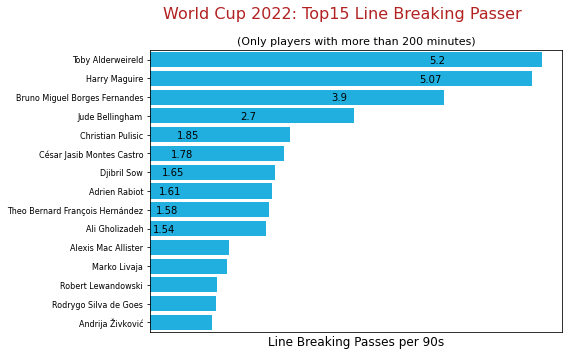

In [82]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
lb_best = players_agg.sort_values('line_breaking_per_90s', ascending = False).head(15).copy()
lb_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = lb_best,x ='line_breaking_per_90s' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Line Breaking Passes per 90s',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(lb_best.index, lb_best['line_breaking_per_90s']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 Line Breaking Passer',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

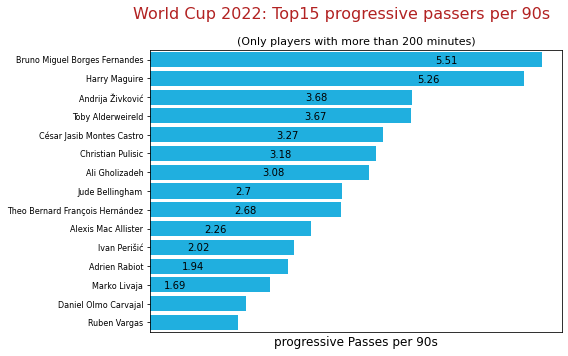

In [83]:
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
Progressive_best = players_agg.sort_values('progressive_passes_per_90s', ascending = False).head(15).copy()
Progressive_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = Progressive_best,x ='progressive_passes_per_90s' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('progressive Passes per 90s',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(Progressive_best.index, Progressive_best['progressive_passes_per_90s']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 progressive passers per 90s',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

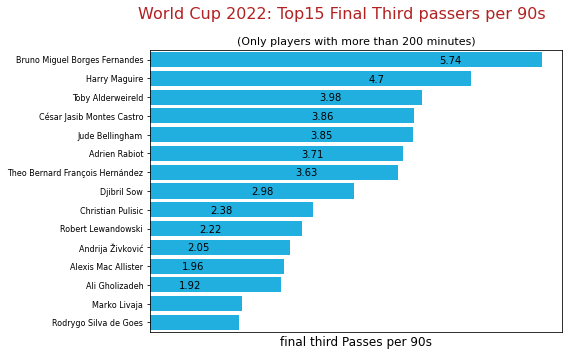

In [85]:
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
FinalThird_best = players_agg.sort_values('finalThird_passes_per_90s', ascending = False).head(15).copy()
FinalThird_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = FinalThird_best,x ='finalThird_passes_per_90s' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('final third Passes per 90s',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(FinalThird_best.index, FinalThird_best['finalThird_passes_per_90s']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 Final Third passers per 90s',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

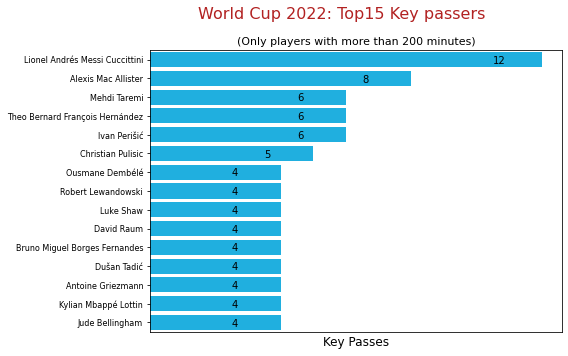

In [224]:
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
KP_best = players_agg.sort_values('Key_passes', ascending = False).head(15).copy()
KP_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = KP_best,x ='Key_passes' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Key Passes',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(KP_best.index, KP_best['Key_passes']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 Key passers',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

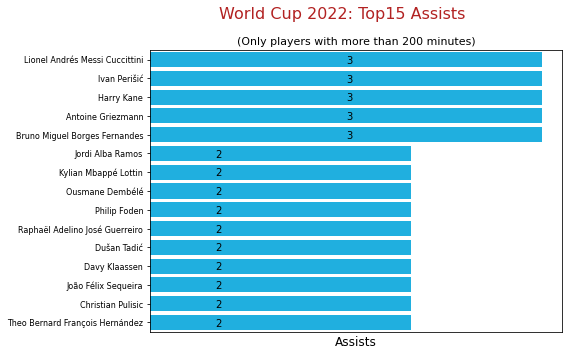

In [211]:
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
KP_best = players_agg.sort_values('Assists', ascending = False).head(15).copy()
KP_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = KP_best,x ='Assists' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Assists',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(KP_best.index, KP_best['Assists']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 Assists',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

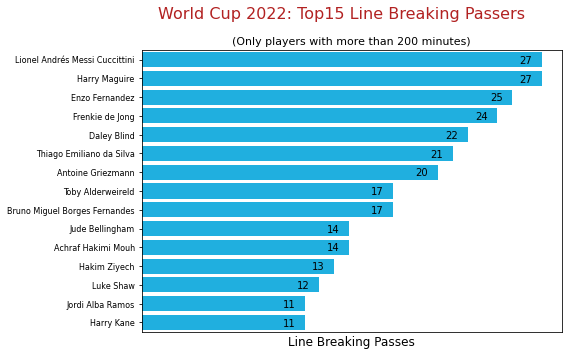

In [223]:
# Create the plot and choose figure size 
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

# Find best 15 players
lb_best = players_agg.sort_values('line_breaking_passes', ascending = False).head(15).copy()
lb_best.reset_index(inplace = True)

# Plot the data: barplot for the top15
sns.barplot(data = lb_best,x ='line_breaking_passes' , y = 'player_name', color = 'deepskyblue', ax = ax)

# Set axis labels and ticks
ax.set_xlabel('Line Breaking Passes',size = 12)
ax.set_ylabel('',size = 9)
plt.yticks(fontsize=8)
plt.xticks([ ])

# Write the correspoding value for each bar
for index_val,x in zip(lb_best.index, lb_best['line_breaking_passes']):
    ax.annotate(str(x),(x-1.5, index_val +0.2),size = 10)


# Write titles
fig.suptitle('World Cup 2022: Top15 Line Breaking Passers',size = 16, x = 0.6, color = 'firebrick')
plt.title('(Only players with more than 200 minutes)',size = 11,ha = 'center')

# Tight layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()

In [18]:
Enzo_agg = players_agg.loc[players_agg['player_name'] == 'Enzo Fernandez']
Enzo_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.5,6.22,2.8,4.98,6.16,10.95,56.27,88.94,0.42,0.75,0.14,0.25


In [310]:
players_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,79.0,0.87,4.55,0.44,2.27
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,88.0,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,90.0,1.20,3.32,0.15,0.41
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.0,0.34,1.09,0.34,1.09
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.50,6.22,2.80,4.98,6.16,10.95,56.27,89.0,0.42,0.75,0.14,0.25
19,Frenkie de Jong,350,CM,Netherlands,5,525,318,24,33,17,3,1,4.11,7.55,2.91,5.35,5.66,10.38,54.51,91.0,0.51,0.94,0.17,0.31
30,Jude Bellingham,264,CM,England,5,467,238,14,20,14,4,1,2.70,5.88,2.70,5.88,3.85,8.40,45.87,90.0,0.77,1.68,0.19,0.42
45,Steven Berghuis,111,CM,Netherlands,4,233,91,7,16,11,1,1,2.70,7.69,4.25,12.09,6.18,17.58,35.15,82.0,0.39,1.10,0.39,1.10


In [108]:
Enzo_per_90 = summary_per_90s.loc[summary_per_90s['player_name'] == 'Enzo Fernandez']
Enzo_per_90

,player_name,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
18,Enzo Fernandez,CM,Argentina,7,643,3.5,6.22,2.8,4.98,6.16,10.95,56.27,89.0,0.42,0.75,0.14,0.25


In [403]:
def role(row):
    if row['starting_position_name'] == 'Goalkeeper':
        return 'GK'
    elif row['starting_position_name'] in fullbacks:
        return 'FB'
    elif row['starting_position_name'] in centerbacks:
        return 'CB'
    elif row['starting_position_name'] in midfielders:
        return 'CM'
    elif row['starting_position_name'] in attacking_midfielders:
        return 'CAM'
    elif row['starting_position_name'] in wingers:
        return 'Wing'
    elif row['starting_position_name'] in forwards:
        return 'CF'
    else:
        return 'Substitute'

# Create a column with *role* that specifies the aggregate role for each player
player_games['role'] = player_games.apply(role,axis = 1)

In [424]:
# Find all player pass attempts and filter by player's minutes.
player_attempts_CM = player_attempts.loc[player_attempts.most_common_role == 'CM']
player_attempts_CM

,player_name,attempts,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,206,CM,Australia,4,401
1,Aaron Ramsey,102,CM,Wales,3,292
2,Abdelhamid Sabiri,56,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,87,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,77,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
310,William Silva de Carvalho,160,CM,Portugal,4,241
312,Woo-Young Jung,204,CM,South Korea,4,324
318,Yeltsin Ignacio Tejeda Valverde,97,CM,Costa Rica,3,292
321,Youssouf Fofana,108,CM,France,6,262


In [52]:
player_attempts_CM.sort
player_attempts_CM["player_Rank"] = player_attempts_CM["attempts"].rank(ascending = False)
player_attempts_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/3264081516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_attempts_CM["Rank"] = player_attempts_CM["attempts"].rank()


,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Rank
0,Aaron Mooy,206,CM,Australia,4,401,46.0
1,Aaron Ramsey,102,CM,Wales,3,292,11.0
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,2.0
6,Abdulaziz Hatem Mohammed Abdullah,87,CM,Qatar,3,215,7.0
8,Abdulelah Saad Hameed Al-Malki,77,CM,Saudi Arabia,2,203,4.0
...,...,...,...,...,...,...,...
310,William Silva de Carvalho,160,CM,Portugal,4,241,37.5
312,Woo-Young Jung,204,CM,South Korea,4,324,45.0
318,Yeltsin Ignacio Tejeda Valverde,97,CM,Costa Rica,3,292,9.0
321,Youssouf Fofana,108,CM,France,6,262,14.0


In [53]:
df = player_attempts_CM.loc[player_attempts_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Rank
86,Enzo Fernandez,452,CM,Argentina,7,643,66.0


In [54]:
# Find all player pass attempts and filter by player's minutes.
player_passes_CM = player_passes.loc[player_passes.most_common_role == 'CM']
player_passes_CM

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,167,CM,Australia,4,401
1,Aaron Ramsey,83,CM,Wales,3,292
2,Abdelhamid Sabiri,44,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,69,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,64,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
310,William Silva de Carvalho,148,CM,Portugal,4,241
312,Woo-Young Jung,178,CM,South Korea,4,324
318,Yeltsin Ignacio Tejeda Valverde,78,CM,Costa Rica,3,292
321,Youssouf Fofana,93,CM,France,6,262


In [55]:
player_passes_CM['succ_passes_per_90s'] = round((player_passes_CM.succ_passes / player_passes_CM.total_minutes)*90,2)
player_passes_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1264198796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_passes_CM['succ_passes_per_90s'] = round((player_passes_CM.succ_passes / player_passes_CM.total_minutes)*90,2)


,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s
0,Aaron Mooy,167,CM,Australia,4,401,37.48
1,Aaron Ramsey,83,CM,Wales,3,292,25.58
2,Abdelhamid Sabiri,44,CM,Morocco,5,206,19.22
6,Abdulaziz Hatem Mohammed Abdullah,69,CM,Qatar,3,215,28.88
8,Abdulelah Saad Hameed Al-Malki,64,CM,Saudi Arabia,2,203,28.37
...,...,...,...,...,...,...,...
310,William Silva de Carvalho,148,CM,Portugal,4,241,55.27
312,Woo-Young Jung,178,CM,South Korea,4,324,49.44
318,Yeltsin Ignacio Tejeda Valverde,78,CM,Costa Rica,3,292,24.04
321,Youssouf Fofana,93,CM,France,6,262,31.95


In [428]:
player_passes_CM.sort_values(by = 'passes_completion_%', ascending = False, inplace = True)
player_passes_CM['player_Rank_%'] = player_passes_CM['passes_completion_%'].rank(ascending = False)
player_passes_CM['player_Rank_%']= round(player_passes_CM['player_Rank_%'], 0)
player_passes_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/212940287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_passes_CM['player_Rank_%'] = player_passes_CM['passes_completion_%'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/212940287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile,player_Rank_%,player_Rank__%
35,Axel Witsel,154,CM,Belgium,3,294,47.14,96.0,70.0,100.000000,1.0,1.0
74,Declan Rice,299,CM,England,5,475,56.65,95.0,69.0,98.571429,2.0,2.0
174,Leandro Daniel Paredes,214,CM,Argentina,5,259,74.36,94.0,68.0,97.142857,3.0,3.0
267,Salis Abdul Samed,128,CM,Ghana,3,277,41.59,93.0,66.5,95.000000,4.0,4.0
236,Pedro González López,391,CM,Spain,4,386,91.17,93.0,66.5,95.000000,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
178,Luis Gerardo Chávez Magallón,92,CM,Mexico,3,303,27.33,78.0,5.0,7.142857,66.0,66.0
97,Grzegorz Krychowiak,94,CM,Poland,4,363,23.31,77.0,3.5,5.000000,68.0,68.0
264,Saeid Ezatolahi Afagh,64,CM,Iran,3,264,21.82,77.0,3.5,5.000000,68.0,68.0
12,Ahmad Nourollahi,38,CM,Iran,3,248,13.79,75.0,1.5,2.142857,70.0,70.0


In [286]:
player_lb_CM

,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s,player_Rank,Rank,line_breaking_per_90s_percentile,line_breaking_per_90_percentile
0,Aaron Mooy,18,CM,Australia,4,401,4.04,51.0,52.0,67.142857,67.142857
1,Aaron Ramsey,5,CM,Wales,3,292,1.54,6.0,7.0,10.000000,10.000000
2,Abdelhamid Sabiri,1,CM,Morocco,5,206,0.44,1.0,1.5,2.857143,2.857143
6,Abdulaziz Hatem Mohammed Abdullah,6,CM,Qatar,3,215,2.51,9.0,10.0,28.571429,28.571429
8,Abdulelah Saad Hameed Al-Malki,4,CM,Saudi Arabia,2,203,1.77,5.0,5.0,14.285714,14.285714
...,...,...,...,...,...,...,...,...,...,...,...
293,William Silva de Carvalho,8,CM,Portugal,4,241,2.99,17.0,18.0,40.000000,40.000000
295,Woo-Young Jung,10,CM,South Korea,4,324,2.78,23.0,26.0,35.714286,35.714286
301,Yeltsin Ignacio Tejeda Valverde,11,CM,Costa Rica,3,292,3.39,30.0,31.0,56.428571,56.428571
303,Youssouf Fofana,12,CM,France,6,262,4.12,33.0,36.5,70.000000,70.000000


In [429]:
player_lb_CM.sort_values(by = 'line_breaking_per_90_percentile', ascending = False, inplace = True)
player_lb_CM['player_Rank_%'] = player_lb_CM['line_breaking_per_90_percentile'].rank(ascending = False)
player_lb_CM['player_Rank_%']= round(player_lb_CM['player_Rank_%'], 0)
player_lb_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/3008495778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_lb_CM['player_Rank_%'] = player_lb_CM['line_breaking_per_90_percentile'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/3008495778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s,player_Rank,Rank,line_breaking_per_90s_percentile,line_breaking_per_90_percentile,player_Rank_%
163,Leandro Daniel Paredes,25,CM,Argentina,5,259,8.69,65.0,66.0,100.000000,100.000000,1.0
83,Ethan Ampadu,20,CM,Wales,3,276,6.52,54.0,55.0,98.571429,98.571429,2.0
228,Pierre-Emile Højbjerg,20,CM,Denmark,3,299,6.02,54.0,55.0,97.142857,97.142857,3.0
241,Rodrigo Bentancur Colmán,14,CM,Uruguay,3,233,5.41,42.0,44.0,95.714286,95.714286,4.0
110,In-Beom Hwang,22,CM,South Korea,4,369,5.37,59.0,59.0,94.285714,94.285714,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16,Alexis Mac Allister,7,CM,Argentina,6,598,1.05,12.0,14.0,7.142857,7.142857,66.0
256,Selim Amallah,5,CM,Morocco,7,453,0.99,6.0,7.0,5.714286,5.714286,67.0
222,Pablo Martín Páez Gavira,3,CM,Spain,4,301,0.90,3.0,3.5,4.285714,4.285714,68.0
2,Abdelhamid Sabiri,1,CM,Morocco,5,206,0.44,1.0,1.5,2.857143,2.857143,69.0


In [289]:
player_progressive_CM

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s,Rank,progressive_passes_per_90_percentile
0,Aaron Mooy,19,CM,Australia,4,401,4.26,54.0,74.285714
1,Aaron Ramsey,2,CM,Wales,3,292,0.62,2.5,1.428571
2,Abdelhamid Sabiri,2,CM,Morocco,5,206,0.87,2.5,5.714286
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,1.67,9.5,18.571429
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203,0.89,2.5,7.142857
...,...,...,...,...,...,...,...,...,...
304,William Silva de Carvalho,7,CM,Portugal,4,241,2.61,17.5,40.000000
306,Woo-Young Jung,21,CM,South Korea,4,324,5.83,59.5,85.714286
312,Yeltsin Ignacio Tejeda Valverde,5,CM,Costa Rica,3,292,1.54,13.5,15.714286
315,Youssouf Fofana,8,CM,France,6,262,2.75,23.0,45.000000


In [430]:
player_progressive_CM.sort_values(by = 'progressive_passes_per_90_percentile', ascending = False, inplace = True)
player_progressive_CM['player_Rank_%'] = player_progressive_CM['progressive_passes_per_90_percentile'].rank(ascending = False)
player_progressive_CM['player_Rank_%']= round(player_progressive_CM['player_Rank_%'], 0)
player_progressive_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1954491141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_progressive_CM['player_Rank_%'] = player_progressive_CM['progressive_passes_per_90_percentile'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1954491141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s,Rank,progressive_passes_per_90_percentile,player_Rank_%
303,Weston McKennie,25,CM,United States,4,283,7.95,64.0,100.000000,1.0
235,Pierre-Emile Højbjerg,22,CM,Denmark,3,299,6.62,61.5,98.571429,2.0
112,In-Beom Hwang,27,CM,South Korea,4,369,6.59,67.0,97.142857,3.0
230,Pedro González López,28,CM,Spain,4,386,6.53,68.0,95.714286,4.0
84,Ethan Ampadu,20,CM,Wales,3,276,6.52,56.5,94.285714,5.0
...,...,...,...,...,...,...,...,...,...,...
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203,0.89,2.5,7.142857,66.0
2,Abdelhamid Sabiri,2,CM,Morocco,5,206,0.87,2.5,5.714286,67.0
265,Selim Amallah,4,CM,Morocco,7,453,0.79,9.5,4.285714,68.0
261,Salis Abdul Samed,2,CM,Ghana,3,277,0.65,2.5,2.857143,69.0


In [293]:
player_IntoFinalThird_CM

,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes,Rank,IntoFinalThird_per_90s,IntoFinalThird_CM_per_90_percentile,IntoFinalThird_per_90_percentile,IntoFinalThird_per_90s_percentile
0,Aaron Mooy,22,CM,Australia,4,401,51.0,4.94,70.000000,70.000000,70.000000
1,Aaron Ramsey,6,CM,Wales,3,292,11.0,1.85,12.857143,12.857143,12.857143
2,Abdelhamid Sabiri,5,CM,Morocco,5,206,6.5,2.18,21.428571,21.428571,21.428571
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,3.0,1.67,10.000000,10.000000,10.000000
8,Abdulelah Saad Hameed Al-Malki,6,CM,Saudi Arabia,2,203,11.0,2.66,27.142857,27.142857,27.142857
...,...,...,...,...,...,...,...,...,...,...,...
292,William Silva de Carvalho,9,CM,Portugal,4,241,19.5,3.36,38.571429,38.571429,38.571429
294,Woo-Young Jung,27,CM,South Korea,4,324,61.0,7.50,94.285714,94.285714,94.285714
299,Yeltsin Ignacio Tejeda Valverde,4,CM,Costa Rica,3,292,3.0,1.23,5.714286,5.714286,5.714286
302,Youssouf Fofana,11,CM,France,6,262,25.5,3.78,47.142857,47.142857,47.142857


In [431]:
player_IntoFinalThird_CM.sort_values(by = 'IntoFinalThird_per_90s_percentile', ascending = False, inplace = True)
player_IntoFinalThird_CM['player_Rank_%'] = player_IntoFinalThird_CM['IntoFinalThird_per_90s_percentile'].rank(ascending = False)
player_IntoFinalThird_CM['player_Rank_%']= round(player_IntoFinalThird_CM['player_Rank_%'], 0)
player_IntoFinalThird_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/290788615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_IntoFinalThird_CM['player_Rank_%'] = player_IntoFinalThird_CM['IntoFinalThird_per_90s_percentile'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/290788615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes,Rank,IntoFinalThird_per_90s,IntoFinalThird_CM_per_90_percentile,IntoFinalThird_per_90_percentile,IntoFinalThird_per_90s_percentile,player_Rank_%
222,Pedro González López,63,CM,Spain,4,386,70.0,14.69,100.000000,100.000000,100.000000,1.0
248,Rúben Diogo Da Silva Neves,25,CM,Portugal,5,279,57.5,8.06,98.571429,98.571429,98.571429,2.0
169,Luka Modrić,62,CM,Croatia,7,699,69.0,7.98,97.142857,97.142857,97.142857,3.0
133,Joshua Kimmich,26,CM,Germany,3,302,59.0,7.75,95.714286,95.714286,95.714286,4.0
294,Woo-Young Jung,27,CM,South Korea,4,324,61.0,7.50,94.285714,94.285714,94.285714,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
221,Pablo Martín Páez Gavira,5,CM,Spain,4,301,6.5,1.50,7.142857,7.142857,7.142857,66.0
299,Yeltsin Ignacio Tejeda Valverde,4,CM,Costa Rica,3,292,3.0,1.23,5.714286,5.714286,5.714286,67.0
113,Jackson Irvine,5,CM,Australia,4,388,6.5,1.16,4.285714,4.285714,4.285714,68.0
257,Selim Amallah,5,CM,Morocco,7,453,6.5,0.99,2.857143,2.857143,2.857143,69.0


In [295]:
player_KP_CM

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank,KP_per_90s,KP_per_90s_percentile
0,Aaron Ramsey,1,CM,Wales,3,292,10.5,0.31,21.818182
1,Abdelhamid Sabiri,2,CM,Morocco,5,206,26.5,0.87,80.000000
5,Adrien Rabiot,2,CM,France,6,558,26.5,0.32,25.454545
8,Alexis Mac Allister,8,CM,Argentina,6,598,54.0,1.20,95.454545
17,Aurélien Djani Tchouaméni,6,CM,France,7,695,52.5,0.78,74.545455
18,Axel Witsel,1,CM,Belgium,3,294,10.5,0.31,21.818182
20,Azzedine Ounahi,6,CM,Morocco,7,608,52.5,0.89,83.636364
21,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,10.5,0.34,30.000000
22,Bernardo Mota Veiga de Carvalho e Silva,4,CM,Portugal,5,388,46.0,0.93,89.090909
29,Carlos Henrique Casimiro,4,CM,Brazil,4,420,46.0,0.86,78.181818


In [432]:
player_KP_CM.sort_values(by = 'KP_per_90s_percentile', ascending = False, inplace = True)
player_KP_CM['player_Rank_%'] = player_KP_CM['KP_per_90s_percentile'].rank(ascending = False)
player_KP_CM['player_Rank_%']= round(player_KP_CM['player_Rank_%'], 0)
player_KP_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1461443716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_KP_CM['player_Rank_%'] = player_KP_CM['KP_per_90s_percentile'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1461443716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank,KP_per_90s,KP_per_90s_percentile,player_Rank_%
130,Otávio Edmilson da Silva Monteiro,4,CM,Portugal,3,202,46.0,1.78,100.000000,1.0
101,Lucas Tolentino Coelho de Lima,5,CM,Brazil,4,326,50.0,1.38,98.181818,2.0
8,Alexis Mac Allister,8,CM,Argentina,6,598,54.0,1.20,95.454545,4.0
111,Mateo Kovačić,9,CM,Croatia,7,673,55.0,1.20,95.454545,4.0
133,Pedro González López,5,CM,Spain,4,386,50.0,1.17,92.727273,5.0
175,Weston McKennie,3,CM,United States,4,283,38.0,0.95,90.909091,6.0
22,Bernardo Mota Veiga de Carvalho e Silva,4,CM,Portugal,5,388,46.0,0.93,89.090909,7.0
132,Pablo Martín Páez Gavira,3,CM,Spain,4,301,38.0,0.90,87.272727,8.0
20,Azzedine Ounahi,6,CM,Morocco,7,608,52.5,0.89,83.636364,10.0
66,Hidemasa Morita,3,CM,Japan,3,305,38.0,0.89,83.636364,10.0


In [297]:
player_Assists_CM

,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank,Assists_per_90s,Assists_per_90s_percentile
0,Abdelhamid Sabiri,1,CM,Morocco,5,206,5.0,0.44,100.000000
2,Adrien Rabiot,1,CM,France,6,558,5.0,0.16,33.333333
3,Alexis Mac Allister,1,CM,Argentina,6,598,5.0,0.15,22.222222
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,5.0,0.34,77.777778
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0,0.14,11.111111
22,Frenkie de Jong,1,CM,Netherlands,5,525,5.0,0.17,44.444444
34,Jude Bellingham,1,CM,England,5,467,5.0,0.19,55.555556
54,Steven Berghuis,1,CM,Netherlands,4,233,5.0,0.39,88.888889
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292,5.0,0.31,66.666667


In [433]:
player_Assists_CM.sort_values(by = 'Assists_per_90s_percentile', ascending = False, inplace = True)
player_Assists_CM['player_Rank_%'] = player_Assists_CM['Assists_per_90s_percentile'].rank(ascending = False)
player_Assists_CM['player_Rank_%']= round(player_Assists_CM['player_Rank_%'], 0)
player_Assists_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/279009585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_Assists_CM['player_Rank_%'] = player_Assists_CM['Assists_per_90s_percentile'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/279009585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank,Assists_per_90s,Assists_per_90s_percentile,player_Rank_%
0,Abdelhamid Sabiri,1,CM,Morocco,5,206,5.0,0.44,100.000000,1.0
54,Steven Berghuis,1,CM,Netherlands,4,233,5.0,0.39,88.888889,2.0
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,5.0,0.34,77.777778,3.0
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292,5.0,0.31,66.666667,4.0
34,Jude Bellingham,1,CM,England,5,467,5.0,0.19,55.555556,5.0
22,Frenkie de Jong,1,CM,Netherlands,5,525,5.0,0.17,44.444444,6.0
2,Adrien Rabiot,1,CM,France,6,558,5.0,0.16,33.333333,7.0
3,Alexis Mac Allister,1,CM,Argentina,6,598,5.0,0.15,22.222222,8.0
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0,0.14,11.111111,9.0


In [303]:
player_KP_CM.loc[player_KP_CM.player_name == 'Enzo Fernandez']

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank,KP_per_90s,KP_per_90s_percentile,player_Rank_%
51,Enzo Fernandez,3,CM,Argentina,7,643,38.0,0.42,40.909091,34.0


In [237]:
player_passes_CM

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile
0,Aaron Mooy,167,CM,Australia,4,401,37.48,81.0,14.5,20.714286
1,Aaron Ramsey,83,CM,Wales,3,292,25.58,81.0,14.5,20.714286
2,Abdelhamid Sabiri,44,CM,Morocco,5,206,19.22,79.0,7.0,10.000000
6,Abdulaziz Hatem Mohammed Abdullah,69,CM,Qatar,3,215,28.88,79.0,7.0,10.000000
8,Abdulelah Saad Hameed Al-Malki,64,CM,Saudi Arabia,2,203,28.37,83.0,22.0,31.428571
...,...,...,...,...,...,...,...,...,...,...
310,William Silva de Carvalho,148,CM,Portugal,4,241,55.27,92.0,64.0,91.428571
312,Woo-Young Jung,178,CM,South Korea,4,324,49.44,87.0,39.0,55.714286
318,Yeltsin Ignacio Tejeda Valverde,78,CM,Costa Rica,3,292,24.04,80.0,10.0,14.285714
321,Youssouf Fofana,93,CM,France,6,262,31.95,86.0,35.5,50.714286


In [57]:
player_passes_CM['passes_completion_%'] = round((player_passes_CM['succ_passes']) / (player_attempts_CM['attempts'])*100)
player_passes_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2739875642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_passes_CM['passes_completion_%'] = round((player_passes_CM['succ_passes']) / (player_attempts_CM['attempts'])*100)


,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%
0,Aaron Mooy,167,CM,Australia,4,401,37.48,81.0
1,Aaron Ramsey,83,CM,Wales,3,292,25.58,81.0
2,Abdelhamid Sabiri,44,CM,Morocco,5,206,19.22,79.0
6,Abdulaziz Hatem Mohammed Abdullah,69,CM,Qatar,3,215,28.88,79.0
8,Abdulelah Saad Hameed Al-Malki,64,CM,Saudi Arabia,2,203,28.37,83.0
...,...,...,...,...,...,...,...,...
310,William Silva de Carvalho,148,CM,Portugal,4,241,55.27,92.0
312,Woo-Young Jung,178,CM,South Korea,4,324,49.44,87.0
318,Yeltsin Ignacio Tejeda Valverde,78,CM,Costa Rica,3,292,24.04,80.0
321,Youssouf Fofana,93,CM,France,6,262,31.95,86.0


In [125]:
# calculate the percentile rank for each column
rank = player_Assists_CM['Assists_per_90s'].rank(pct=True)

# define a function to calculate the overall percentile rank for each player
def get_percentile_rank(row):
    return rank.loc[row.name].mean() * 100

# apply the function to each row of the dataframe to get the overall percentile rank for each player
player_Assists_CM['Assists_per_90s_percentile'] = player_Assists_CM.apply(get_percentile_rank, axis=1)

# print the dataframe
player_Assists_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2950331914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_Assists_CM['Assists_per_90s_percentile'] = player_Assists_CM.apply(get_percentile_rank, axis=1)


,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank,Assists_per_90s,Assists_per_90s_percentile
0,Abdelhamid Sabiri,1,CM,Morocco,5,206,5.0,0.44,100.000000
2,Adrien Rabiot,1,CM,France,6,558,5.0,0.16,33.333333
3,Alexis Mac Allister,1,CM,Argentina,6,598,5.0,0.15,22.222222
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,5.0,0.34,77.777778
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0,0.14,11.111111
22,Frenkie de Jong,1,CM,Netherlands,5,525,5.0,0.17,44.444444
34,Jude Bellingham,1,CM,England,5,467,5.0,0.19,55.555556
54,Steven Berghuis,1,CM,Netherlands,4,233,5.0,0.39,88.888889
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292,5.0,0.31,66.666667


In [61]:
df = player_passes_CM.loc[player_passes_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile
86,Enzo Fernandez,402,CM,Argentina,7,643,56.27,89.0,48.0,68.571429


In [110]:
player_lb_CM = player_lb.loc[player_lb.most_common_role == 'CM']
player_lb_CM

,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,18,CM,Australia,4,401
1,Aaron Ramsey,5,CM,Wales,3,292
2,Abdelhamid Sabiri,1,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,6,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,4,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
293,William Silva de Carvalho,8,CM,Portugal,4,241
295,Woo-Young Jung,10,CM,South Korea,4,324
301,Yeltsin Ignacio Tejeda Valverde,11,CM,Costa Rica,3,292
303,Youssouf Fofana,12,CM,France,6,262


In [111]:
player_lb_CM['line_breaking_per_90s'] = round((player_lb_CM.line_breaking_passes / player_lb_CM.total_minutes)*90,2)
player_lb_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1959193515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_lb_CM['line_breaking_per_90s'] = round((player_lb_CM.line_breaking_passes / player_lb_CM.total_minutes)*90,2)


,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s
0,Aaron Mooy,18,CM,Australia,4,401,4.04
1,Aaron Ramsey,5,CM,Wales,3,292,1.54
2,Abdelhamid Sabiri,1,CM,Morocco,5,206,0.44
6,Abdulaziz Hatem Mohammed Abdullah,6,CM,Qatar,3,215,2.51
8,Abdulelah Saad Hameed Al-Malki,4,CM,Saudi Arabia,2,203,1.77
...,...,...,...,...,...,...,...
293,William Silva de Carvalho,8,CM,Portugal,4,241,2.99
295,Woo-Young Jung,10,CM,South Korea,4,324,2.78
301,Yeltsin Ignacio Tejeda Valverde,11,CM,Costa Rica,3,292,3.39
303,Youssouf Fofana,12,CM,France,6,262,4.12


In [158]:
mask_a = (passes.line_breaking == True) & (passes.IntoFinalThird == True)
mask_b = (passes.line_breaking == True) & (passes.KeyPasses == True)
mask_c = (passes.line_breaking == True) & (passes.Assists == True)

Enzo_lb_intoFinalThird_passes = passes.loc[(passes.type_name == 'pass') & (passes.result_name == 'success') & mask_a | mask_b | mask_c]
Enzo_lb_intoFinalThird_passes = Enzo_lb_intoFinalThird_passes.loc[Enzo_lb_intoFinalThird_passes['player_id'] == 38718]
Enzo_lb_intoFinalThird_passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False
33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False
45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False
45366,3857264,1a6513f4-9772-45a1-ad5b-21d9ef49719d,2,1159.0,779,38718.0,60.705882,45.017722,71.117647,15.924051,0,1,5,1584,pass,success,foot_right,0.007,False,1.754530,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,False,True,False,False
50223,3869151,397a939a-d39e-42e2-9f7f-24a2a59959df,1,521.0,779,38718.0,59.735294,47.083544,73.941176,48.202532,0,1,5,277,pass,success,foot_right,0.007,False,0.732694,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,foul,freekick_short,success,success,success,True,True,True,False,False
50232,3869151,d25ffd59-653b-4422-be4f-ee7cb2d5a209,1,562.0,779,38718.0,57.970588,47.513924,95.647059,49.837975,0,1,5,295,pass,success,foot_right,0.038,False,2.410391,Enzo Fernandez,Argentina,Julián Álvarez,bad_touch,goalkick,pass,fail,success,success,True,True,True,False,False
50304,3869151,4c691fcb-2707-4d60-9ec2-4e0f6bfc30ab,1,916.0,779,38718.0,68.117647,28.405063,81.000000,65.417722,0,1,5,454,pass,success,foot_right,0.008,False,2.150420,Enzo Fernandez,Argentina,Alejandro Darío Gómez,dribble,pass,dribble,success,success,success,True,False,True,False,False
51158,3869151,010dfd7e-60d5-4d88-9a7e-fb8044e37e96,2,2843.0,779,38718.0,68.117647,24.531646,87.352941,3.098734,0,1,5,2314,pass,success,foot_right,0.008,False,1.022108,Enzo Fernandez,Argentina,Gonzalo Ariel Montiel,dribble,pass,dribble,success,success,success,True,False,True,False,False
52358,3869321,7a509e87-942a-4d18-be0c-fed8e804d7bd,4,512.0,779,38718.0,69.882353,21.346835,101.117647,21.863291,0,1,5,2550,pass,success,foot_right,0.045,False,2.463489,Enzo Fernandez,Argentina,Lautaro Javier Martínez,dribble,pass,interception,success,fail,success,True,True,True,False,False
52826,3869685,6efd0da6-a504-47eb-8f70-cba44425cb9a,1,2543.0,779,38718.0,47.117647,33.913924,89.382353,63.179747,0,1,5,842,pass,success,foot_right,0.020,False,4.600799,Enzo Fernandez,Argentina,Ángel Fabián Di María Hernández,dribble,take_on,tackle,success,fail,success,True,True,True,False,False


In [112]:
df = player_lb_CM.loc[player_lb_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s
82,Enzo Fernandez,25,CM,Argentina,7,643,3.5


In [113]:
player_lb_CM['player_Rank'] = player_lb_CM["line_breaking_passes"].rank(method = 'min')
player_lb_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1526132175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_lb_CM['player_Rank'] = player_lb_CM["line_breaking_passes"].rank(method = 'min')


,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s,player_Rank
0,Aaron Mooy,18,CM,Australia,4,401,4.04,51.0
1,Aaron Ramsey,5,CM,Wales,3,292,1.54,6.0
2,Abdelhamid Sabiri,1,CM,Morocco,5,206,0.44,1.0
6,Abdulaziz Hatem Mohammed Abdullah,6,CM,Qatar,3,215,2.51,9.0
8,Abdulelah Saad Hameed Al-Malki,4,CM,Saudi Arabia,2,203,1.77,5.0
...,...,...,...,...,...,...,...,...
293,William Silva de Carvalho,8,CM,Portugal,4,241,2.99,17.0
295,Woo-Young Jung,10,CM,South Korea,4,324,2.78,23.0
301,Yeltsin Ignacio Tejeda Valverde,11,CM,Costa Rica,3,292,3.39,30.0
303,Youssouf Fofana,12,CM,France,6,262,4.12,33.0


In [114]:
player_lb_CM["Rank"] = player_lb_CM["line_breaking_passes"].rank()
player_lb_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2321565252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_lb_CM["Rank"] = player_lb_CM["line_breaking_passes"].rank()


,player_name,line_breaking_passes,most_common_role,team_name,games_played,total_minutes,line_breaking_per_90s,player_Rank,Rank
0,Aaron Mooy,18,CM,Australia,4,401,4.04,51.0,52.0
1,Aaron Ramsey,5,CM,Wales,3,292,1.54,6.0,7.0
2,Abdelhamid Sabiri,1,CM,Morocco,5,206,0.44,1.0,1.5
6,Abdulaziz Hatem Mohammed Abdullah,6,CM,Qatar,3,215,2.51,9.0,10.0
8,Abdulelah Saad Hameed Al-Malki,4,CM,Saudi Arabia,2,203,1.77,5.0,5.0
...,...,...,...,...,...,...,...,...,...
293,William Silva de Carvalho,8,CM,Portugal,4,241,2.99,17.0,18.0
295,Woo-Young Jung,10,CM,South Korea,4,324,2.78,23.0,26.0
301,Yeltsin Ignacio Tejeda Valverde,11,CM,Costa Rica,3,292,3.39,30.0,31.0
303,Youssouf Fofana,12,CM,France,6,262,4.12,33.0,36.5


In [67]:
player_progressive_CM = Player_progressive_passes.loc[Player_progressive_passes.most_common_role == 'CM']
player_progressive_CM

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,19,CM,Australia,4,401
1,Aaron Ramsey,2,CM,Wales,3,292
2,Abdelhamid Sabiri,2,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
304,William Silva de Carvalho,7,CM,Portugal,4,241
306,Woo-Young Jung,21,CM,South Korea,4,324
312,Yeltsin Ignacio Tejeda Valverde,5,CM,Costa Rica,3,292
315,Youssouf Fofana,8,CM,France,6,262


In [68]:
player_progressive_CM['progressive_passes_per_90s'] = round((player_progressive_CM.Progressive_passes / player_progressive_CM.total_minutes)*90,2)
player_progressive_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2930333416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_progressive_CM['progressive_passes_per_90s'] = round((player_progressive_CM.Progressive_passes / player_progressive_CM.total_minutes)*90,2)


,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s
0,Aaron Mooy,19,CM,Australia,4,401,4.26
1,Aaron Ramsey,2,CM,Wales,3,292,0.62
2,Abdelhamid Sabiri,2,CM,Morocco,5,206,0.87
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,1.67
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203,0.89
...,...,...,...,...,...,...,...
304,William Silva de Carvalho,7,CM,Portugal,4,241,2.61
306,Woo-Young Jung,21,CM,South Korea,4,324,5.83
312,Yeltsin Ignacio Tejeda Valverde,5,CM,Costa Rica,3,292,1.54
315,Youssouf Fofana,8,CM,France,6,262,2.75


In [69]:
player_progressive_CM["Rank"] = player_progressive_CM["Progressive_passes"].rank()
player_progressive_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/33208526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_progressive_CM["Rank"] = player_progressive_CM["Progressive_passes"].rank()


,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s,Rank
0,Aaron Mooy,19,CM,Australia,4,401,4.26,54.0
1,Aaron Ramsey,2,CM,Wales,3,292,0.62,2.5
2,Abdelhamid Sabiri,2,CM,Morocco,5,206,0.87,2.5
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,1.67,9.5
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203,0.89,2.5
...,...,...,...,...,...,...,...,...
304,William Silva de Carvalho,7,CM,Portugal,4,241,2.61,17.5
306,Woo-Young Jung,21,CM,South Korea,4,324,5.83,59.5
312,Yeltsin Ignacio Tejeda Valverde,5,CM,Costa Rica,3,292,1.54,13.5
315,Youssouf Fofana,8,CM,France,6,262,2.75,23.0


In [70]:
df = player_progressive_CM.loc[player_progressive_CM['player_name'] == 'Enzo Fernandez' ]
df

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s,Rank
83,Enzo Fernandez,20,CM,Argentina,7,643,2.8,56.5


In [71]:
player_IntoFinalThird_CM = player_FinalThird.loc[player_FinalThird.most_common_role == 'CM']
player_IntoFinalThird_CM

,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,22,CM,Australia,4,401
1,Aaron Ramsey,6,CM,Wales,3,292
2,Abdelhamid Sabiri,5,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,6,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
292,William Silva de Carvalho,9,CM,Portugal,4,241
294,Woo-Young Jung,27,CM,South Korea,4,324
299,Yeltsin Ignacio Tejeda Valverde,4,CM,Costa Rica,3,292
302,Youssouf Fofana,11,CM,France,6,262


In [72]:
player_IntoFinalThird_CM["Rank"] = player_IntoFinalThird_CM["IntoFinalThird"].rank()
player_IntoFinalThird_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/908870375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_IntoFinalThird_CM["Rank"] = player_IntoFinalThird_CM["IntoFinalThird"].rank()


,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes,Rank
0,Aaron Mooy,22,CM,Australia,4,401,51.0
1,Aaron Ramsey,6,CM,Wales,3,292,11.0
2,Abdelhamid Sabiri,5,CM,Morocco,5,206,6.5
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,3.0
8,Abdulelah Saad Hameed Al-Malki,6,CM,Saudi Arabia,2,203,11.0
...,...,...,...,...,...,...,...
292,William Silva de Carvalho,9,CM,Portugal,4,241,19.5
294,Woo-Young Jung,27,CM,South Korea,4,324,61.0
299,Yeltsin Ignacio Tejeda Valverde,4,CM,Costa Rica,3,292,3.0
302,Youssouf Fofana,11,CM,France,6,262,25.5


In [73]:
df = player_IntoFinalThird_CM.loc[player_IntoFinalThird_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes,Rank
82,Enzo Fernandez,44,CM,Argentina,7,643,66.0


In [74]:
player_IntoFinalThird_CM['IntoFinalThird_per_90s'] = round((player_IntoFinalThird_CM.IntoFinalThird / player_IntoFinalThird_CM.total_minutes)*90,2)
player_IntoFinalThird_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1523629785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_IntoFinalThird_CM['IntoFinalThird_per_90s'] = round((player_IntoFinalThird_CM.IntoFinalThird / player_IntoFinalThird_CM.total_minutes)*90,2)


,player_name,IntoFinalThird,most_common_role,team_name,games_played,total_minutes,Rank,IntoFinalThird_per_90s
0,Aaron Mooy,22,CM,Australia,4,401,51.0,4.94
1,Aaron Ramsey,6,CM,Wales,3,292,11.0,1.85
2,Abdelhamid Sabiri,5,CM,Morocco,5,206,6.5,2.18
6,Abdulaziz Hatem Mohammed Abdullah,4,CM,Qatar,3,215,3.0,1.67
8,Abdulelah Saad Hameed Al-Malki,6,CM,Saudi Arabia,2,203,11.0,2.66
...,...,...,...,...,...,...,...,...
292,William Silva de Carvalho,9,CM,Portugal,4,241,19.5,3.36
294,Woo-Young Jung,27,CM,South Korea,4,324,61.0,7.50
299,Yeltsin Ignacio Tejeda Valverde,4,CM,Costa Rica,3,292,3.0,1.23
302,Youssouf Fofana,11,CM,France,6,262,25.5,3.78


In [75]:
player_KP_CM = Player_KP.loc[Player_KP.most_common_role == 'CM']
player_KP_CM

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes
0,Aaron Ramsey,1,CM,Wales,3,292
1,Abdelhamid Sabiri,2,CM,Morocco,5,206
5,Adrien Rabiot,2,CM,France,6,558
8,Alexis Mac Allister,8,CM,Argentina,6,598
17,Aurélien Djani Tchouaméni,6,CM,France,7,695
18,Axel Witsel,1,CM,Belgium,3,294
20,Azzedine Ounahi,6,CM,Morocco,7,608
21,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266
22,Bernardo Mota Veiga de Carvalho e Silva,4,CM,Portugal,5,388
29,Carlos Henrique Casimiro,4,CM,Brazil,4,420


In [76]:
player_KP_CM["Rank"] = player_KP_CM["Key_passes"].rank()
player_KP_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/918283104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_KP_CM["Rank"] = player_KP_CM["Key_passes"].rank()


,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank
0,Aaron Ramsey,1,CM,Wales,3,292,10.5
1,Abdelhamid Sabiri,2,CM,Morocco,5,206,26.5
5,Adrien Rabiot,2,CM,France,6,558,26.5
8,Alexis Mac Allister,8,CM,Argentina,6,598,54.0
17,Aurélien Djani Tchouaméni,6,CM,France,7,695,52.5
18,Axel Witsel,1,CM,Belgium,3,294,10.5
20,Azzedine Ounahi,6,CM,Morocco,7,608,52.5
21,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,10.5
22,Bernardo Mota Veiga de Carvalho e Silva,4,CM,Portugal,5,388,46.0
29,Carlos Henrique Casimiro,4,CM,Brazil,4,420,46.0


In [77]:
df = player_KP_CM.loc[player_KP_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank
51,Enzo Fernandez,3,CM,Argentina,7,643,38.0


In [78]:
player_KP_CM['KP_per_90s'] = round((player_KP_CM.Key_passes / player_KP_CM.total_minutes)*90,2)
player_KP_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/1346382640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_KP_CM['KP_per_90s'] = round((player_KP_CM.Key_passes / player_KP_CM.total_minutes)*90,2)


,player_name,Key_passes,most_common_role,team_name,games_played,total_minutes,Rank,KP_per_90s
0,Aaron Ramsey,1,CM,Wales,3,292,10.5,0.31
1,Abdelhamid Sabiri,2,CM,Morocco,5,206,26.5,0.87
5,Adrien Rabiot,2,CM,France,6,558,26.5,0.32
8,Alexis Mac Allister,8,CM,Argentina,6,598,54.0,1.20
17,Aurélien Djani Tchouaméni,6,CM,France,7,695,52.5,0.78
18,Axel Witsel,1,CM,Belgium,3,294,10.5,0.31
20,Azzedine Ounahi,6,CM,Morocco,7,608,52.5,0.89
21,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,10.5,0.34
22,Bernardo Mota Veiga de Carvalho e Silva,4,CM,Portugal,5,388,46.0,0.93
29,Carlos Henrique Casimiro,4,CM,Brazil,4,420,46.0,0.86


In [79]:
player_Assists_CM = Player_Assists.loc[Player_Assists.most_common_role == 'CM']
player_Assists_CM

,player_name,Assists,most_common_role,team_name,games_played,total_minutes
0,Abdelhamid Sabiri,1,CM,Morocco,5,206
2,Adrien Rabiot,1,CM,France,6,558
3,Alexis Mac Allister,1,CM,Argentina,6,598
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266
20,Enzo Fernandez,1,CM,Argentina,7,643
22,Frenkie de Jong,1,CM,Netherlands,5,525
34,Jude Bellingham,1,CM,England,5,467
54,Steven Berghuis,1,CM,Netherlands,4,233
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292


In [80]:
player_Assists_CM["Rank"] = player_Assists_CM["Assists"].rank()
player_Assists_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/389732276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_Assists_CM["Rank"] = player_Assists_CM["Assists"].rank()


,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank
0,Abdelhamid Sabiri,1,CM,Morocco,5,206,5.0
2,Adrien Rabiot,1,CM,France,6,558,5.0
3,Alexis Mac Allister,1,CM,Argentina,6,598,5.0
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,5.0
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0
22,Frenkie de Jong,1,CM,Netherlands,5,525,5.0
34,Jude Bellingham,1,CM,England,5,467,5.0
54,Steven Berghuis,1,CM,Netherlands,4,233,5.0
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292,5.0


In [81]:
player_Assists_CM['Assists_per_90s'] = round((player_Assists_CM.Assists / player_Assists_CM.total_minutes)*90,2)
player_Assists_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/995408979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_Assists_CM['Assists_per_90s'] = round((player_Assists_CM.Assists / player_Assists_CM.total_minutes)*90,2)


,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank,Assists_per_90s
0,Abdelhamid Sabiri,1,CM,Morocco,5,206,5.0,0.44
2,Adrien Rabiot,1,CM,France,6,558,5.0,0.16
3,Alexis Mac Allister,1,CM,Argentina,6,598,5.0,0.15
8,Aïssa Bilal Laïdouni,1,CM,Tunisia,3,266,5.0,0.34
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0,0.14
22,Frenkie de Jong,1,CM,Netherlands,5,525,5.0,0.17
34,Jude Bellingham,1,CM,England,5,467,5.0,0.19
54,Steven Berghuis,1,CM,Netherlands,4,233,5.0,0.39
62,Yeltsin Ignacio Tejeda Valverde,1,CM,Costa Rica,3,292,5.0,0.31


In [82]:
df = player_Assists_CM.loc[player_Assists_CM['player_name'] == 'Enzo Fernandez']
df

,player_name,Assists,most_common_role,team_name,games_played,total_minutes,Rank,Assists_per_90s
20,Enzo Fernandez,1,CM,Argentina,7,643,5.0,0.14


In [83]:
Player_progressive_passes_xT = passes.loc[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.is_progressive == True)]
Player_progressive_passes_xT.reset_index(inplace = True)
Player_progressive_passes_xT = Player_progressive_passes_xT.merge(players, on = 'player_name')

Player_progressive_passes_xT = Player_progressive_passes_xT.loc[Player_progressive_passes_xT['most_common_role'] == 'CM']
Player_progressive_passes_xT_Enzo = Player_progressive_passes_xT.loc[Player_progressive_passes_xT['player_id'] == 38718]
Player_progressive_passes_xT_Enzo

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name_x,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists,most_common_role,team_name_y,games_played,total_minutes
2812,32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2813,32986,3869519,c0f61a57-db4e-4a4e-8ca4-1c35a5d2727b,1,1298.0,779,38718.0,53.558824,34.344304,68.823529,29.954430,0,1,5,612,pass,success,foot_right,0.003,False,0.919136,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,True,True,False,False,False,CM,Argentina,7,643
2814,33026,3869519,a073ad71-7f26-4ff0-b9cf-a7b35e115c20,1,1447.0,779,38718.0,65.117647,51.817722,99.882353,50.784810,0,1,5,689,pass,success,foot_right,0.046,False,2.552646,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,cross,dribble,pass,fail,success,fail,False,True,True,False,False,CM,Argentina,7,643
2815,33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False,CM,Argentina,7,643
2816,45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2817,49901,3857289,85115aa4-eee4-4dd2-8310-a8cbb6d92546,2,1764.0,779,38718.0,53.558824,11.706329,60.176471,24.187342,0,1,5,1535,pass,success,foot_right,0.001,False,1.101479,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,tackle,dribble,success,success,success,False,True,False,False,False,CM,Argentina,7,643
2818,49923,3857289,11248d3b-e972-46d8-9eb8-79669f96d119,2,1889.0,779,38718.0,44.205882,38.820253,73.676471,50.268354,0,1,5,1584,pass,success,foot_right,0.009,False,2.527365,Enzo Fernandez,Argentina,Julián Álvarez,dribble,cross,dribble,success,success,success,False,True,True,False,False,CM,Argentina,7,643
2819,49950,3857289,6c74b6ee-e829-4dc1-9f68-00f2ad34bdc9,2,2038.0,779,38718.0,50.382353,14.891139,68.294118,15.321519,0,1,0,1643,pass,success,foot,0.005,True,1.030658,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,False,False,False,CM,Argentina,7,643
2820,50223,3869151,397a939a-d39e-42e2-9f7f-24a2a59959df,1,521.0,779,38718.0,59.735294,47.083544,73.941176,48.202532,0,1,5,277,pass,success,foot_right,0.007,False,0.732694,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,foul,freekick_short,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2821,50232,3869151,d25ffd59-653b-4422-be4f-ee7cb2d5a209,1,562.0,779,38718.0,57.970588,47.513924,95.647059,49.837975,0,1,5,295,pass,success,foot_right,0.038,False,2.410391,Enzo Fernandez,Argentina,Julián Álvarez,bad_touch,goalkick,pass,fail,success,success,True,True,True,False,False,CM,Argentina,7,643


In [84]:
Player_line_breaking_passes_xT = passes.loc[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.line_breaking == True)]
Player_line_breaking_passes_xT.reset_index(inplace = True)
Player_line_breaking_passes_xT = Player_line_breaking_passes_xT.merge(players, on = 'player_name')

Player_line_breaking_passes_xT = Player_line_breaking_passes_xT.loc[Player_line_breaking_passes_xT['most_common_role'] == 'CM']
Player_line_breaking_passes_xT_Enzo = Player_line_breaking_passes_xT.loc[Player_line_breaking_passes_xT['player_id'] == 38718]
Player_line_breaking_passes_xT_Enzo

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name_x,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists,most_common_role,team_name_y,games_played,total_minutes
2230,32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2231,32986,3869519,c0f61a57-db4e-4a4e-8ca4-1c35a5d2727b,1,1298.0,779,38718.0,53.558824,34.344304,68.823529,29.954430,0,1,5,612,pass,success,foot_right,0.003,False,0.919136,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,True,True,False,False,False,CM,Argentina,7,643
2232,33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False,CM,Argentina,7,643
2233,33111,3869519,011efae4-9918-4169-9f84-6f91e34b2349,1,2138.0,779,38718.0,31.676471,18.764557,45.441176,27.802532,0,1,5,896,pass,success,foot_right,0.004,True,1.073320,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,pass,success,fail,success,True,False,False,False,False,CM,Argentina,7,643
2234,45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2235,45366,3857264,1a6513f4-9772-45a1-ad5b-21d9ef49719d,2,1159.0,779,38718.0,60.705882,45.017722,71.117647,15.924051,0,1,5,1584,pass,success,foot_right,0.007,False,1.754530,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,False,True,False,False,CM,Argentina,7,643
2236,49950,3857289,6c74b6ee-e829-4dc1-9f68-00f2ad34bdc9,2,2038.0,779,38718.0,50.382353,14.891139,68.294118,15.321519,0,1,0,1643,pass,success,foot,0.005,True,1.030658,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,False,False,False,CM,Argentina,7,643
2237,50091,3869151,affdda93-219e-48db-b260-430aecdb1b5d,1,38.0,779,38718.0,6.176471,46.567089,23.382353,48.718987,0,1,1,11,pass,success,head,0.001,False,1.556177,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,pass,dribble,pass,success,success,success,True,False,False,False,False,CM,Argentina,7,643
2238,50223,3869151,397a939a-d39e-42e2-9f7f-24a2a59959df,1,521.0,779,38718.0,59.735294,47.083544,73.941176,48.202532,0,1,5,277,pass,success,foot_right,0.007,False,0.732694,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,foul,freekick_short,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2239,50232,3869151,d25ffd59-653b-4422-be4f-ee7cb2d5a209,1,562.0,779,38718.0,57.970588,47.513924,95.647059,49.837975,0,1,5,295,pass,success,foot_right,0.038,False,2.410391,Enzo Fernandez,Argentina,Julián Álvarez,bad_touch,goalkick,pass,fail,success,success,True,True,True,False,False,CM,Argentina,7,643


In [85]:
Player_IntoFinalThird_passes_xT = passes.loc[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.IntoFinalThird == True)]
Player_IntoFinalThird_passes_xT.reset_index(inplace = True)
Player_IntoFinalThird_passes_xT = Player_IntoFinalThird_passes_xT.merge(players, on = 'player_name')

Player_IntoFinalThird_passes_xT = Player_IntoFinalThird_passes_xT.loc[Player_IntoFinalThird_passes_xT['most_common_role'] == 'CM']
Player_IntoFinalThird_passes_xT_Enzo = Player_IntoFinalThird_passes_xT.loc[Player_IntoFinalThird_passes_xT['player_id'] == 38718]
Player_IntoFinalThird_passes_xT_Enzo

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name_x,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists,most_common_role,team_name_y,games_played,total_minutes
2654,32770,3869519,eeb706c7-a9f5-4fe3-95ea-8a32214a37fe,1,289.0,779,38718.0,65.470588,60.855696,70.411765,65.848101,0,1,5,137,pass,success,foot_right,0.004,False,1.237419,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,pass,dribble,pass,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2655,32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2656,33026,3869519,a073ad71-7f26-4ff0-b9cf-a7b35e115c20,1,1447.0,779,38718.0,65.117647,51.817722,99.882353,50.784810,0,1,5,689,pass,success,foot_right,0.046,False,2.552646,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,cross,dribble,pass,fail,success,fail,False,True,True,False,False,CM,Argentina,7,643
2657,33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False,CM,Argentina,7,643
2658,44756,3857264,d435d789-5f58-4553-9a5c-d40c726182ef,1,645.0,779,38718.0,64.147059,16.870886,83.558824,1.807595,0,1,5,250,pass,success,foot_right,0.009,False,1.384683,Enzo Fernandez,Argentina,Ángel Fabián Di María Hernández,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2659,44758,3857264,63db46c0-3d46-45e6-89f2-0dba21683b90,1,657.0,779,38718.0,66.441176,16.698734,78.970588,3.098734,0,1,5,254,pass,success,foot_right,0.009,False,1.179114,Enzo Fernandez,Argentina,Nahuel Molina Lucero,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2660,44816,3857264,8f453e26-39c1-47c3-8193-17fb03e4c5b5,1,961.0,779,38718.0,65.029412,39.508861,70.147059,22.293671,0,1,5,385,pass,success,foot_right,0.004,False,1.302733,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2661,44876,3857264,67ab82a3-9062-445a-9a1c-5bb6cfad463f,1,1331.0,779,38718.0,64.764706,35.721519,70.764706,20.055696,0,1,5,510,pass,success,foot_right,0.004,False,1.092193,Enzo Fernandez,Argentina,Rodrigo Javier De Paul,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2662,45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2663,45029,3857264,3d97e78e-9a8c-47e9-b850-b6a07222f7f0,1,2037.0,779,38718.0,65.735294,17.559494,75.529412,7.660759,0,1,5,832,pass,success,foot_right,0.002,False,1.129684,Enzo Fernandez,Argentina,Rodrigo Javier De Paul,dribble,cross,clearance,success,fail,success,False,False,True,False,False,CM,Argentina,7,643


In [86]:
player_passes_Enzo = passes.loc[(passes.type_name == 'pass') & (passes.result_name =='success') & (passes.player_id == 38718)]
player_passes_Enzo

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
32742,3869519,f29deb60-ac58-41e7-9aae-ce8fad5ee3b6,1,176.0,779,38718.0,40.058824,47.513924,38.117647,23.670886,0,1,5,80,pass,success,foot_right,0.000,False,2.189791,Enzo Fernandez,Argentina,Cristian Gabriel Romero,dribble,pass,dribble,success,success,success,False,False,False,False,False
32765,3869519,68c4ca31-7919-4766-82a8-1025e38e69f7,1,272.0,779,38718.0,67.235294,63.782278,63.705882,54.141772,0,1,5,124,pass,success,foot_right,0.001,False,0.746402,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,bad_touch,dribble,success,fail,success,False,False,False,False,False
32770,3869519,eeb706c7-a9f5-4fe3-95ea-8a32214a37fe,1,289.0,779,38718.0,65.470588,60.855696,70.411765,65.848101,0,1,5,137,pass,success,foot_right,0.004,False,1.237419,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,pass,dribble,pass,success,success,success,False,False,True,False,False
32772,3869519,138fde36-e031-46e6-9943-9bc25189088f,1,292.0,779,38718.0,66.705882,61.113924,67.411765,45.448101,0,1,5,140,pass,success,foot_right,0.002,False,1.192140,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,False,False,False,False,False
32775,3869519,5ee73d98-7840-415a-b39e-085c5f75265d,1,303.0,779,38718.0,72.529412,60.855696,70.058824,52.334177,0,1,5,146,pass,success,foot_right,0.003,False,0.883115,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,pass,dribble,success,success,success,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54362,3857300,a9454dfc-ce9d-4de5-b507-c91b35b57948,2,2925.0,779,38718.0,61.058824,59.478481,69.529412,64.470886,0,1,5,1812,pass,success,foot_right,0.001,False,0.933538,Enzo Fernandez,Argentina,Marcos Javier Acuña,pass,dribble,tackle,success,success,fail,False,False,False,False,False
54375,3857300,5610da07-6edf-4ef6-8e90-d7bf520c09c7,2,3238.0,779,38718.0,66.705882,53.453165,81.970588,64.470886,0,1,4,1844,pass,success,foot_left,0.009,False,1.230255,Enzo Fernandez,Argentina,Marcos Javier Acuña,dribble,pass,pass,success,success,fail,False,False,True,False,False
54379,3857300,08617777-07b3-4f2f-a790-6aa7f4edd50c,2,3249.0,779,38718.0,64.852941,62.835443,95.382353,48.632911,0,1,5,1852,pass,success,foot_right,0.037,False,2.263133,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,corner_crossed,success,fail,fail,True,True,True,False,False
54399,3857300,841d395d-7fb4-41f5-b90d-28fee71d8713,2,3352.0,779,38718.0,11.205882,48.460759,12.529412,33.397468,0,1,5,1893,pass,success,foot_right,0.001,False,1.175060,Enzo Fernandez,Argentina,Nicolás Hernán Otamendi,dribble,pass,dribble,success,success,success,False,False,False,False,False


In [87]:
player_attempts_Enzo = passes.loc[(passes.type_name == 'pass') & (passes.player_id == 38718)]
player_attempts_Enzo

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
32742,3869519,f29deb60-ac58-41e7-9aae-ce8fad5ee3b6,1,176.0,779,38718.0,40.058824,47.513924,38.117647,23.670886,0,1,5,80,pass,success,foot_right,0.000,False,2.189791,Enzo Fernandez,Argentina,Cristian Gabriel Romero,dribble,pass,dribble,success,success,success,False,False,False,False,False
32765,3869519,68c4ca31-7919-4766-82a8-1025e38e69f7,1,272.0,779,38718.0,67.235294,63.782278,63.705882,54.141772,0,1,5,124,pass,success,foot_right,0.001,False,0.746402,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,bad_touch,dribble,success,fail,success,False,False,False,False,False
32770,3869519,eeb706c7-a9f5-4fe3-95ea-8a32214a37fe,1,289.0,779,38718.0,65.470588,60.855696,70.411765,65.848101,0,1,5,137,pass,success,foot_right,0.004,False,1.237419,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,pass,dribble,pass,success,success,success,False,False,True,False,False
32772,3869519,138fde36-e031-46e6-9943-9bc25189088f,1,292.0,779,38718.0,66.705882,61.113924,67.411765,45.448101,0,1,5,140,pass,success,foot_right,0.002,False,1.192140,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,False,False,False,False,False
32775,3869519,5ee73d98-7840-415a-b39e-085c5f75265d,1,303.0,779,38718.0,72.529412,60.855696,70.058824,52.334177,0,1,5,146,pass,success,foot_right,0.003,False,0.883115,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,pass,dribble,success,success,success,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54379,3857300,08617777-07b3-4f2f-a790-6aa7f4edd50c,2,3249.0,779,38718.0,64.852941,62.835443,95.382353,48.632911,0,1,5,1852,pass,success,foot_right,0.037,False,2.263133,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,corner_crossed,success,fail,fail,True,True,True,False,False
54399,3857300,841d395d-7fb4-41f5-b90d-28fee71d8713,2,3352.0,779,38718.0,11.205882,48.460759,12.529412,33.397468,0,1,5,1893,pass,success,foot_right,0.001,False,1.175060,Enzo Fernandez,Argentina,Nicolás Hernán Otamendi,dribble,pass,dribble,success,success,success,False,False,False,False,False
54404,3857300,afe0df79-71ba-4cc2-abd1-5188d899c4c3,2,3435.0,779,38718.0,17.823529,56.896203,47.294118,58.187342,0,0,4,1904,pass,fail,foot_left,NaN,False,2.854254,Enzo Fernandez,Argentina,Abdulelah Al Amri,dribble,pass,goalkick,success,fail,success,True,False,False,False,False
54419,3857300,ebe44531-1adb-4c93-b5c8-8143b350fd14,2,3506.0,779,38718.0,59.735294,54.572152,87.264706,10.329114,0,0,5,1937,pass,fail,foot_right,NaN,False,2.968449,Enzo Fernandez,Argentina,Mohammed Al Burayk,interception,dribble,pass,fail,success,fail,True,True,True,False,False


In [467]:
# Find all player pass attempts and filter by player's minutes.
player_under_pressure_attempts = passes[(passes.type_name == 'pass') & (passes.under_pressure == True)].groupby('player_name')[['type_name']].agg({'type_name':'count'})
player_under_pressure_attempts.reset_index(inplace = True)
player_under_pressure_attempts = player_under_pressure_attempts.merge(players, on = 'player_name')

# Rename columnso
player_under_pressure_attempts = player_under_pressure_attempts.rename(columns = {'type_name':'Pass_under_pressure_attempts'})
player_under_pressure_attempts

,player_name,Pass_under_pressure_attempts,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,25,CM,Australia,4,401
1,Aaron Ramsey,23,CM,Wales,3,292
2,Abdelhamid Sabiri,11,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,21,CB,Qatar,3,302
4,Abdou Diallo,16,CB,Senegal,4,365
...,...,...,...,...,...,...
324,Yuto Nagatomo,14,FB,Japan,4,217
325,Álvaro Borja Morata Martín,11,CF,Spain,4,208
326,Ángel Fabián Di María Hernández,23,Wing,Argentina,5,323
327,Éder Gabriel Militão,19,FB,Brazil,4,374


In [468]:
player_under_pressure_success = passes[(passes.type_name == 'pass') & (passes.under_pressure == True) & (passes.result_name == 'success')].groupby('player_name')[['type_name']].agg({'type_name':'count'})
player_under_pressure_success.reset_index(inplace = True)
player_under_pressure_success = player_under_pressure_success.merge(players, on = 'player_name')

# Rename columnso
player_under_pressure_success = player_under_pressure_success.rename(columns = {'type_name':'Pass_under_pressure_success'})
player_under_pressure_success

,player_name,Pass_under_pressure_success,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,13,CM,Australia,4,401
1,Aaron Ramsey,20,CM,Wales,3,292
2,Abdelhamid Sabiri,7,CM,Morocco,5,206
3,Abdelkarim Hassan Al Haj Fadlalla,17,CB,Qatar,3,302
4,Abdou Diallo,9,CB,Senegal,4,365
...,...,...,...,...,...,...
322,Yuto Nagatomo,9,FB,Japan,4,217
323,Álvaro Borja Morata Martín,8,CF,Spain,4,208
324,Ángel Fabián Di María Hernández,19,Wing,Argentina,5,323
325,Éder Gabriel Militão,11,FB,Brazil,4,374


In [469]:
player_under_pressure_success_CM = player_under_pressure_success.loc[player_under_pressure_success.most_common_role == 'CM']
player_under_pressure_success_CM

,player_name,Pass_under_pressure_success,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,13,CM,Australia,4,401
1,Aaron Ramsey,20,CM,Wales,3,292
2,Abdelhamid Sabiri,7,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,12,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,7,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
308,William Silva de Carvalho,14,CM,Portugal,4,241
310,Woo-Young Jung,14,CM,South Korea,4,324
316,Yeltsin Ignacio Tejeda Valverde,13,CM,Costa Rica,3,292
319,Youssouf Fofana,5,CM,France,6,262


In [471]:
player_under_pressure_CM = pd.merge(player_under_pressure_attempts_CM, player_under_pressure_success_CM, on = 'player_name', how = 'left' )
player_under_pressure_CM

,player_name,Pass_under_pressure_attempts,most_common_role_x,team_name_x,games_played_x,total_minutes_x,Pass_under_pressure_success,most_common_role_y,team_name_y,games_played_y,total_minutes_y
0,Aaron Mooy,25,CM,Australia,4,401,13,CM,Australia,4,401
1,Aaron Ramsey,23,CM,Wales,3,292,20,CM,Wales,3,292
2,Abdelhamid Sabiri,11,CM,Morocco,5,206,7,CM,Morocco,5,206
3,Abdulaziz Hatem Mohammed Abdullah,18,CM,Qatar,3,215,12,CM,Qatar,3,215
4,Abdulelah Saad Hameed Al-Malki,10,CM,Saudi Arabia,2,203,7,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...,...,...,...,...,...
65,William Silva de Carvalho,19,CM,Portugal,4,241,14,CM,Portugal,4,241
66,Woo-Young Jung,19,CM,South Korea,4,324,14,CM,South Korea,4,324
67,Yeltsin Ignacio Tejeda Valverde,19,CM,Costa Rica,3,292,13,CM,Costa Rica,3,292
68,Youssouf Fofana,7,CM,France,6,262,5,CM,France,6,262


In [473]:
player_under_pressure_CM['under_pressure_completion_%'] = round((player_under_pressure_CM.Pass_under_pressure_success) / (player_under_pressure_CM.Pass_under_pressure_attempts)*100, 2)
player_under_pressure_CM

,player_name,Pass_under_pressure_attempts,most_common_role_x,team_name_x,games_played_x,total_minutes_x,Pass_under_pressure_success,most_common_role_y,team_name_y,games_played_y,total_minutes_y,under_pressure_completion_%
0,Aaron Mooy,25,CM,Australia,4,401,13,CM,Australia,4,401,52.00
1,Aaron Ramsey,23,CM,Wales,3,292,20,CM,Wales,3,292,86.96
2,Abdelhamid Sabiri,11,CM,Morocco,5,206,7,CM,Morocco,5,206,63.64
3,Abdulaziz Hatem Mohammed Abdullah,18,CM,Qatar,3,215,12,CM,Qatar,3,215,66.67
4,Abdulelah Saad Hameed Al-Malki,10,CM,Saudi Arabia,2,203,7,CM,Saudi Arabia,2,203,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...
65,William Silva de Carvalho,19,CM,Portugal,4,241,14,CM,Portugal,4,241,73.68
66,Woo-Young Jung,19,CM,South Korea,4,324,14,CM,South Korea,4,324,73.68
67,Yeltsin Ignacio Tejeda Valverde,19,CM,Costa Rica,3,292,13,CM,Costa Rica,3,292,68.42
68,Youssouf Fofana,7,CM,France,6,262,5,CM,France,6,262,71.43


In [475]:
player_under_pressure_CM.sort_values(by = 'under_pressure_completion_%', ascending = False, inplace = True)
player_under_pressure_CM['player_Rank_%'] = player_under_pressure_CM['under_pressure_completion_%'].rank(ascending = False)
player_under_pressure_CM['player_Rank_%']= round(player_under_pressure_CM['player_Rank_%'], 0)
player_under_pressure_CM

,player_name,Pass_under_pressure_attempts,most_common_role_x,team_name_x,games_played_x,total_minutes_x,Pass_under_pressure_success,most_common_role_y,team_name_y,games_played_y,total_minutes_y,under_pressure_completion_%,player_Rank_%
54,Salis Abdul Samed,15,CM,Ghana,3,277,15,CM,Ghana,3,277,100.00,1.0
69,Yunus Dimoara Musah,23,CM,United States,4,375,22,CM,United States,4,375,95.65,2.0
10,Axel Witsel,20,CM,Belgium,3,294,19,CM,Belgium,3,294,95.00,3.0
40,Matías Vecino Falero,14,CM,Uruguay,3,216,13,CM,Uruguay,3,216,92.86,4.0
33,Krystian Bielik,12,CM,Poland,4,254,11,CM,Poland,4,254,91.67,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,Mohammed Kanoo,27,CM,Saudi Arabia,3,319,17,CM,Saudi Arabia,3,319,62.96,66.0
20,Ethan Ampadu,25,CM,Wales,3,276,15,CM,Wales,3,276,60.00,67.0
32,Karim Boudiaf,15,CM,Qatar,3,208,8,CM,Qatar,3,208,53.33,68.0
0,Aaron Mooy,25,CM,Australia,4,401,13,CM,Australia,4,401,52.00,69.0


In [476]:
# calculate the percentile rank for each column
rank = player_under_pressure_CM['under_pressure_completion_%'].rank(pct=True)

# define a function to calculate the overall percentile rank for each player
def get_percentile_rank(row):
    return rank.loc[row.name].mean() * 5

# apply the function to each row of the dataframe to get the overall percentile rank for each player
player_under_pressure_CM['percentile_under_pressure_completion_%'] = player_under_pressure_CM.apply(get_percentile_rank, axis=1)

# print the dataframe
player_under_pressure_CM

,player_name,Pass_under_pressure_attempts,most_common_role_x,team_name_x,games_played_x,total_minutes_x,Pass_under_pressure_success,most_common_role_y,team_name_y,games_played_y,total_minutes_y,under_pressure_completion_%,player_Rank_%,percentile_under_pressure_completion_%
54,Salis Abdul Samed,15,CM,Ghana,3,277,15,CM,Ghana,3,277,100.00,1.0,5.000000
69,Yunus Dimoara Musah,23,CM,United States,4,375,22,CM,United States,4,375,95.65,2.0,4.928571
10,Axel Witsel,20,CM,Belgium,3,294,19,CM,Belgium,3,294,95.00,3.0,4.857143
40,Matías Vecino Falero,14,CM,Uruguay,3,216,13,CM,Uruguay,3,216,92.86,4.0,4.785714
33,Krystian Bielik,12,CM,Poland,4,254,11,CM,Poland,4,254,91.67,5.0,4.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,Mohammed Kanoo,27,CM,Saudi Arabia,3,319,17,CM,Saudi Arabia,3,319,62.96,66.0,0.357143
20,Ethan Ampadu,25,CM,Wales,3,276,15,CM,Wales,3,276,60.00,67.0,0.285714
32,Karim Boudiaf,15,CM,Qatar,3,208,8,CM,Qatar,3,208,53.33,68.0,0.214286
0,Aaron Mooy,25,CM,Australia,4,401,13,CM,Australia,4,401,52.00,69.0,0.142857


In [478]:
player_under_pressure_CM.loc[player_under_pressure_CM.player_name == 'Enzo Fernandez']

,player_name,Pass_under_pressure_attempts,most_common_role_x,team_name_x,games_played_x,total_minutes_x,Pass_under_pressure_success,most_common_role_y,team_name_y,games_played_y,total_minutes_y,under_pressure_completion_%,player_Rank_%,percentile_under_pressure_completion_%
19,Enzo Fernandez,38,CM,Argentina,7,643,28,CM,Argentina,7,643,73.68,45.0,1.857143


In [470]:
player_under_pressure_attempts_CM = player_under_pressure_attempts.loc[player_under_pressure_attempts.most_common_role == 'CM']
player_under_pressure_attempts_CM

,player_name,Pass_under_pressure_attempts,most_common_role,team_name,games_played,total_minutes
0,Aaron Mooy,25,CM,Australia,4,401
1,Aaron Ramsey,23,CM,Wales,3,292
2,Abdelhamid Sabiri,11,CM,Morocco,5,206
6,Abdulaziz Hatem Mohammed Abdullah,18,CM,Qatar,3,215
8,Abdulelah Saad Hameed Al-Malki,10,CM,Saudi Arabia,2,203
...,...,...,...,...,...,...
310,William Silva de Carvalho,19,CM,Portugal,4,241
312,Woo-Young Jung,19,CM,South Korea,4,324
318,Yeltsin Ignacio Tejeda Valverde,19,CM,Costa Rica,3,292
321,Youssouf Fofana,7,CM,France,6,262


In [89]:
Enzo_pass_under_pressure_attempts = passes.loc[(passes.type_name == 'pass') & (passes.under_pressure == True) & (passes.player_id == 38718)]
Enzo_pass_under_pressure_attempts

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
32791,3869519,f9b5a2f4-152d-4066-89f8-9a49ca162e85,1,406.0,779,38718.0,50.382353,62.663291,28.676471,54.227848,0,1,5,186,pass,success,foot_right,-0.002,True,1.608296,Enzo Fernandez,Argentina,Nicolás Hernán Otamendi,dribble,pass,dribble,success,success,success,False,False,False,False,False
32879,3869519,3433374d-cf0d-4092-be7e-28330227d8a5,1,760.0,779,38718.0,48.794118,50.784810,42.176471,24.617722,0,1,5,379,pass,success,foot_right,-0.002,True,1.777465,Enzo Fernandez,Argentina,Cristian Gabriel Romero,dribble,pass,dribble,success,success,success,False,False,False,False,False
33111,3869519,011efae4-9918-4169-9f84-6f91e34b2349,1,2138.0,779,38718.0,31.676471,18.764557,45.441176,27.802532,0,1,5,896,pass,success,foot_right,0.004,True,1.073320,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,pass,success,fail,success,True,False,False,False,False
33313,3869519,44b0a16a-8d04-4268-8cf8-fca9442e75b0,2,404.0,779,38718.0,30.176471,37.443038,31.941176,40.197468,0,0,5,1350,pass,fail,foot_right,NaN,True,1.929098,Enzo Fernandez,Argentina,Nikola Vlašić,dribble,pass,dribble,success,success,success,False,False,False,False,False
33389,3869519,f8bbaba3-3593-4982-b955-a24e640ca694,2,723.0,779,38718.0,89.029412,42.435443,95.029412,44.070886,0,1,5,1508,pass,success,foot_right,-0.053,True,0.843085,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,shot,keeper_save,success,fail,success,False,False,False,True,False
33512,3869519,1d6c71b7-b427-44f7-bd65-b80e5f081ac5,2,1847.0,779,38718.0,58.235294,48.632911,66.352941,50.698734,0,1,0,1818,pass,success,foot,0.002,True,1.725240,Enzo Fernandez,Argentina,Paulo Bruno Exequiel Dybala,pass,dribble,pass,fail,success,success,False,False,False,False,False
44675,3857264,ce19d84c-ea8d-40e3-a8f0-afbc41b029e8,1,192.0,779,38718.0,38.205882,49.149367,37.676471,68.000000,0,0,0,46,pass,fail,foot,NaN,True,2.995249,Enzo Fernandez,Argentina,Matty Cash,throw_in,tackle,dribble,success,success,success,False,False,False,False,False
45083,3857264,f7bdf6d1-89fc-44d3-a22a-9cd8b0743836,1,2556.0,779,38718.0,38.823529,46.222785,49.323529,34.086076,0,0,0,964,pass,fail,foot,NaN,True,1.867791,Enzo Fernandez,Argentina,Krystian Bielik,pass,pass,dribble,success,success,success,True,False,False,False,False
49950,3857289,6c74b6ee-e829-4dc1-9f68-00f2ad34bdc9,2,2038.0,779,38718.0,50.382353,14.891139,68.294118,15.321519,0,1,0,1643,pass,success,foot,0.005,True,1.030658,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,False,False,False
50020,3857289,329230e9-fc51-4cb5-849b-882d3b4dd19a,2,2717.0,779,38718.0,27.264706,2.668354,38.911765,3.098734,0,0,5,1806,pass,fail,foot_right,NaN,True,0.570153,Enzo Fernandez,Argentina,Héctor Miguel Herrera López,dribble,take_on,tackle,success,fail,success,False,False,False,False,False


In [90]:
# Find all player pass attempts and filter by player's minutes.
Enzo_pass_under_pressure_success = passes[(passes.type_name == 'pass') & (passes.under_pressure == True) & (passes.result_name == 'success') & (passes.player_id == 38718)].groupby('player_name')[['type_name']].agg({'type_name':'count'})
Enzo_pass_under_pressure_success.reset_index(inplace = True)
Enzo_pass_under_pressure_success = Enzo_pass_under_pressure_success.merge(players, on = 'player_name')

# Rename columnso
Enzo_pass_under_pressure_success = Enzo_pass_under_pressure_success.rename(columns = {'type_name':'Pass under pressure success'})
Enzo_pass_under_pressure_success


,player_name,Pass under pressure success,most_common_role,team_name,games_played,total_minutes
0,Enzo Fernandez,28,CM,Argentina,7,643


In [91]:
Enzo_pass_under_pressure = pd.merge(Enzo_pass_under_pressure_attempts, Enzo_pass_under_pressure_success, how='left')
Enzo_pass_under_pressure

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists,Pass under pressure success,most_common_role,games_played,total_minutes
0,3869519,f9b5a2f4-152d-4066-89f8-9a49ca162e85,1,406.0,779,38718.0,50.382353,62.663291,28.676471,54.227848,0,1,5,186,pass,success,foot_right,-0.002,True,1.608296,Enzo Fernandez,Argentina,Nicolás Hernán Otamendi,dribble,pass,dribble,success,success,success,False,False,False,False,False,28,CM,7,643
1,3869519,3433374d-cf0d-4092-be7e-28330227d8a5,1,760.0,779,38718.0,48.794118,50.784810,42.176471,24.617722,0,1,5,379,pass,success,foot_right,-0.002,True,1.777465,Enzo Fernandez,Argentina,Cristian Gabriel Romero,dribble,pass,dribble,success,success,success,False,False,False,False,False,28,CM,7,643
2,3869519,011efae4-9918-4169-9f84-6f91e34b2349,1,2138.0,779,38718.0,31.676471,18.764557,45.441176,27.802532,0,1,5,896,pass,success,foot_right,0.004,True,1.073320,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,pass,success,fail,success,True,False,False,False,False,28,CM,7,643
3,3869519,44b0a16a-8d04-4268-8cf8-fca9442e75b0,2,404.0,779,38718.0,30.176471,37.443038,31.941176,40.197468,0,0,5,1350,pass,fail,foot_right,NaN,True,1.929098,Enzo Fernandez,Argentina,Nikola Vlašić,dribble,pass,dribble,success,success,success,False,False,False,False,False,28,CM,7,643
4,3869519,f8bbaba3-3593-4982-b955-a24e640ca694,2,723.0,779,38718.0,89.029412,42.435443,95.029412,44.070886,0,1,5,1508,pass,success,foot_right,-0.053,True,0.843085,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,shot,keeper_save,success,fail,success,False,False,False,True,False,28,CM,7,643
5,3869519,1d6c71b7-b427-44f7-bd65-b80e5f081ac5,2,1847.0,779,38718.0,58.235294,48.632911,66.352941,50.698734,0,1,0,1818,pass,success,foot,0.002,True,1.725240,Enzo Fernandez,Argentina,Paulo Bruno Exequiel Dybala,pass,dribble,pass,fail,success,success,False,False,False,False,False,28,CM,7,643
6,3857264,ce19d84c-ea8d-40e3-a8f0-afbc41b029e8,1,192.0,779,38718.0,38.205882,49.149367,37.676471,68.000000,0,0,0,46,pass,fail,foot,NaN,True,2.995249,Enzo Fernandez,Argentina,Matty Cash,throw_in,tackle,dribble,success,success,success,False,False,False,False,False,28,CM,7,643
7,3857264,f7bdf6d1-89fc-44d3-a22a-9cd8b0743836,1,2556.0,779,38718.0,38.823529,46.222785,49.323529,34.086076,0,0,0,964,pass,fail,foot,NaN,True,1.867791,Enzo Fernandez,Argentina,Krystian Bielik,pass,pass,dribble,success,success,success,True,False,False,False,False,28,CM,7,643
8,3857289,6c74b6ee-e829-4dc1-9f68-00f2ad34bdc9,2,2038.0,779,38718.0,50.382353,14.891139,68.294118,15.321519,0,1,0,1643,pass,success,foot,0.005,True,1.030658,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,False,False,False,28,CM,7,643
9,3857289,329230e9-fc51-4cb5-849b-882d3b4dd19a,2,2717.0,779,38718.0,27.264706,2.668354,38.911765,3.098734,0,0,5,1806,pass,fail,foot_right,NaN,True,0.570153,Enzo Fernandez,Argentina,Héctor Miguel Herrera López,dribble,take_on,tackle,success,fail,success,False,False,False,False,False,28,CM,7,643


In [93]:
font_normal = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto%5Bwdth,wght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')

In [94]:
players_agg['pass_completion_%'] = round((players_agg['succ_passes']) / (players_agg['attempts']) *100 )
players_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,79.0,0.87,4.55,0.44,2.27
1,Achraf Hakimi Mouh,294,FB,Morocco,7,681,245,14,12,15,2,1,1.85,5.71,1.98,6.12,1.59,4.90,32.38,83.0,0.26,0.82,0.13,0.41
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,88.0,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,90.0,1.20,3.32,0.15,0.41
4,Ali Gholizadeh,63,Wing,Iran,3,234,43,4,5,8,1,1,1.54,9.30,3.08,18.60,1.92,11.63,16.54,68.0,0.38,2.33,0.38,2.33
5,Andrija Živković,73,FB,Serbia,3,220,60,2,5,9,2,2,0.82,3.33,3.68,15.00,2.05,8.33,24.55,82.0,0.82,3.33,0.82,3.33
6,Angelo Smit Preciado Quiñónez,92,FB,Ecuador,3,289,72,4,7,8,1,1,1.25,5.56,2.49,11.11,2.18,9.72,22.42,78.0,0.31,1.39,0.31,1.39
7,Antoine Griezmann,267,CAM,France,7,608,229,20,26,15,4,3,2.96,8.73,2.22,6.55,3.85,11.35,33.90,86.0,0.59,1.75,0.44,1.31
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.0,0.34,1.09,0.34,1.09
9,Bruno Miguel Borges Fernandes,196,Wing,Portugal,4,392,167,17,25,24,4,3,3.90,10.18,5.51,14.37,5.74,14.97,38.34,85.0,0.92,2.40,0.69,1.80


In [95]:
players_agg = players_agg.loc[players_agg.most_common_role == 'CM']
players_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,79.0,0.87,4.55,0.44,2.27
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,88.0,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,90.0,1.20,3.32,0.15,0.41
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.0,0.34,1.09,0.34,1.09
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.50,6.22,2.80,4.98,6.16,10.95,56.27,89.0,0.42,0.75,0.14,0.25
19,Frenkie de Jong,350,CM,Netherlands,5,525,318,24,33,17,3,1,4.11,7.55,2.91,5.35,5.66,10.38,54.51,91.0,0.51,0.94,0.17,0.31
30,Jude Bellingham,264,CM,England,5,467,238,14,20,14,4,1,2.70,5.88,2.70,5.88,3.85,8.40,45.87,90.0,0.77,1.68,0.19,0.42
45,Steven Berghuis,111,CM,Netherlands,4,233,91,7,16,11,1,1,2.70,7.69,4.25,12.09,6.18,17.58,35.15,82.0,0.39,1.10,0.39,1.10


In [96]:
Enzo_pass_completion = players_agg.loc[players_agg.player_name == 'Enzo Fernandez']
Enzo_pass_completion

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.5,6.22,2.8,4.98,6.16,10.95,56.27,89.0,0.42,0.75,0.14,0.25


In [97]:
Player_IntoFinalThird_passes_xT_Enzo

,index,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name_x,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists,most_common_role,team_name_y,games_played,total_minutes
2654,32770,3869519,eeb706c7-a9f5-4fe3-95ea-8a32214a37fe,1,289.0,779,38718.0,65.470588,60.855696,70.411765,65.848101,0,1,5,137,pass,success,foot_right,0.004,False,1.237419,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,pass,dribble,pass,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2655,32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2656,33026,3869519,a073ad71-7f26-4ff0-b9cf-a7b35e115c20,1,1447.0,779,38718.0,65.117647,51.817722,99.882353,50.784810,0,1,5,689,pass,success,foot_right,0.046,False,2.552646,Enzo Fernandez,Argentina,Nicolás Alejandro Tagliafico,cross,dribble,pass,fail,success,fail,False,True,True,False,False,CM,Argentina,7,643
2657,33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False,CM,Argentina,7,643
2658,44756,3857264,d435d789-5f58-4553-9a5c-d40c726182ef,1,645.0,779,38718.0,64.147059,16.870886,83.558824,1.807595,0,1,5,250,pass,success,foot_right,0.009,False,1.384683,Enzo Fernandez,Argentina,Ángel Fabián Di María Hernández,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2659,44758,3857264,63db46c0-3d46-45e6-89f2-0dba21683b90,1,657.0,779,38718.0,66.441176,16.698734,78.970588,3.098734,0,1,5,254,pass,success,foot_right,0.009,False,1.179114,Enzo Fernandez,Argentina,Nahuel Molina Lucero,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2660,44816,3857264,8f453e26-39c1-47c3-8193-17fb03e4c5b5,1,961.0,779,38718.0,65.029412,39.508861,70.147059,22.293671,0,1,5,385,pass,success,foot_right,0.004,False,1.302733,Enzo Fernandez,Argentina,Lionel Andrés Messi Cuccittini,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2661,44876,3857264,67ab82a3-9062-445a-9a1c-5bb6cfad463f,1,1331.0,779,38718.0,64.764706,35.721519,70.764706,20.055696,0,1,5,510,pass,success,foot_right,0.004,False,1.092193,Enzo Fernandez,Argentina,Rodrigo Javier De Paul,dribble,pass,dribble,success,success,success,False,False,True,False,False,CM,Argentina,7,643
2662,45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False,CM,Argentina,7,643
2663,45029,3857264,3d97e78e-9a8c-47e9-b850-b6a07222f7f0,1,2037.0,779,38718.0,65.735294,17.559494,75.529412,7.660759,0,1,5,832,pass,success,foot_right,0.002,False,1.129684,Enzo Fernandez,Argentina,Rodrigo Javier De Paul,dribble,cross,clearance,success,fail,success,False,False,True,False,False,CM,Argentina,7,643


In [204]:
Enzo_lb_intoFinalThird_passes

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT,under_pressure,duration,player_name,team_name,next_player,next_action,second_next_action,Third_next_action,next_action_result,second_next_action_result,Third_next_action_result,line_breaking,is_progressive,IntoFinalThird,KeyPasses,Assists
32888,3869519,ce8be511-5e26-4cc6-8244-9ba67881b82c,1,782.0,779,38718.0,56.558824,62.663291,74.470588,63.868354,0,1,5,397,pass,success,foot_right,0.006,False,0.980301,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False
33099,3869519,65292ba3-916f-408a-9541-303c30089caf,1,1866.0,779,38718.0,50.735294,53.022785,83.735294,37.959494,0,1,5,867,pass,success,foot_right,0.021,False,2.254330,Enzo Fernandez,Argentina,Julián Álvarez,dribble,foul,shot_penalty,success,yellow_card,success,True,True,True,False,False
45025,3857264,d91fe68c-e8c2-4f7b-baf4-559d0b2223c9,1,2030.0,779,38718.0,54.352941,22.293671,71.294118,22.551899,0,1,5,825,pass,success,foot_right,0.007,False,1.140768,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,True,True,False,False
45366,3857264,1a6513f4-9772-45a1-ad5b-21d9ef49719d,2,1159.0,779,38718.0,60.705882,45.017722,71.117647,15.924051,0,1,5,1584,pass,success,foot_right,0.007,False,1.754530,Enzo Fernandez,Argentina,Julián Álvarez,dribble,pass,dribble,success,success,success,True,False,True,False,False
50223,3869151,397a939a-d39e-42e2-9f7f-24a2a59959df,1,521.0,779,38718.0,59.735294,47.083544,73.941176,48.202532,0,1,5,277,pass,success,foot_right,0.007,False,0.732694,Enzo Fernandez,Argentina,Alexis Mac Allister,dribble,foul,freekick_short,success,success,success,True,True,True,False,False
50232,3869151,d25ffd59-653b-4422-be4f-ee7cb2d5a209,1,562.0,779,38718.0,57.970588,47.513924,95.647059,49.837975,0,1,5,295,pass,success,foot_right,0.038,False,2.410391,Enzo Fernandez,Argentina,Julián Álvarez,bad_touch,goalkick,pass,fail,success,success,True,True,True,False,False
50304,3869151,4c691fcb-2707-4d60-9ec2-4e0f6bfc30ab,1,916.0,779,38718.0,68.117647,28.405063,81.000000,65.417722,0,1,5,454,pass,success,foot_right,0.008,False,2.150420,Enzo Fernandez,Argentina,Alejandro Darío Gómez,dribble,pass,dribble,success,success,success,True,False,True,False,False
51158,3869151,010dfd7e-60d5-4d88-9a7e-fb8044e37e96,2,2843.0,779,38718.0,68.117647,24.531646,87.352941,3.098734,0,1,5,2314,pass,success,foot_right,0.008,False,1.022108,Enzo Fernandez,Argentina,Gonzalo Ariel Montiel,dribble,pass,dribble,success,success,success,True,False,True,False,False
52358,3869321,7a509e87-942a-4d18-be0c-fed8e804d7bd,4,512.0,779,38718.0,69.882353,21.346835,101.117647,21.863291,0,1,5,2550,pass,success,foot_right,0.045,False,2.463489,Enzo Fernandez,Argentina,Lautaro Javier Martínez,dribble,pass,interception,success,fail,success,True,True,True,False,False
52826,3869685,6efd0da6-a504-47eb-8f70-cba44425cb9a,1,2543.0,779,38718.0,47.117647,33.913924,89.382353,63.179747,0,1,5,842,pass,success,foot_right,0.020,False,4.600799,Enzo Fernandez,Argentina,Ángel Fabián Di María Hernández,dribble,take_on,tackle,success,fail,success,True,True,True,False,False


In [264]:
player_passes_CM.sort_values(by="player_Rank", ascending=True)

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile
12,Ahmad Nourollahi,38,CM,Iran,3,248,13.79,75.0,1.5,2.142857
87,Ethan Ampadu,100,CM,Wales,3,276,32.61,75.0,1.5,2.142857
97,Grzegorz Krychowiak,94,CM,Poland,4,363,23.31,77.0,3.5,5.000000
264,Saeid Ezatolahi Afagh,64,CM,Iran,3,264,21.82,77.0,3.5,5.000000
178,Luis Gerardo Chávez Magallón,92,CM,Mexico,3,303,27.33,78.0,5.0,7.142857
...,...,...,...,...,...,...,...,...,...,...
236,Pedro González López,391,CM,Spain,4,386,91.17,93.0,66.5,95.000000
267,Salis Abdul Samed,128,CM,Ghana,3,277,41.59,93.0,66.5,95.000000
174,Leandro Daniel Paredes,214,CM,Argentina,5,259,74.36,94.0,68.0,97.142857
74,Declan Rice,299,CM,England,5,475,56.65,95.0,69.0,98.571429


In [266]:
player_passes_CM.reset_index(drop=True)

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile
0,Aaron Mooy,167,CM,Australia,4,401,37.48,81.0,14.5,20.714286
1,Aaron Ramsey,83,CM,Wales,3,292,25.58,81.0,14.5,20.714286
2,Abdelhamid Sabiri,44,CM,Morocco,5,206,19.22,79.0,7.0,10.000000
3,Abdulaziz Hatem Mohammed Abdullah,69,CM,Qatar,3,215,28.88,79.0,7.0,10.000000
4,Abdulelah Saad Hameed Al-Malki,64,CM,Saudi Arabia,2,203,28.37,83.0,22.0,31.428571
...,...,...,...,...,...,...,...,...,...,...
65,William Silva de Carvalho,148,CM,Portugal,4,241,55.27,92.0,64.0,91.428571
66,Woo-Young Jung,178,CM,South Korea,4,324,49.44,87.0,39.0,55.714286
67,Yeltsin Ignacio Tejeda Valverde,78,CM,Costa Rica,3,292,24.04,80.0,10.0,14.285714
68,Youssouf Fofana,93,CM,France,6,262,31.95,86.0,35.5,50.714286


In [305]:
player_passes_CM

,player_name,succ_passes,most_common_role,team_name,games_played,total_minutes,succ_passes_per_90s,passes_completion_%,player_Rank,pass_completion_%_percentile,player_Rank_%,player_Rank__%
35,Axel Witsel,154,CM,Belgium,3,294,47.14,96.0,70.0,100.000000,1.0,1.0
74,Declan Rice,299,CM,England,5,475,56.65,95.0,69.0,98.571429,2.0,2.0
174,Leandro Daniel Paredes,214,CM,Argentina,5,259,74.36,94.0,68.0,97.142857,3.0,3.0
267,Salis Abdul Samed,128,CM,Ghana,3,277,41.59,93.0,66.5,95.000000,4.0,4.0
236,Pedro González López,391,CM,Spain,4,386,91.17,93.0,66.5,95.000000,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
178,Luis Gerardo Chávez Magallón,92,CM,Mexico,3,303,27.33,78.0,5.0,7.142857,66.0,66.0
97,Grzegorz Krychowiak,94,CM,Poland,4,363,23.31,77.0,3.5,5.000000,68.0,68.0
264,Saeid Ezatolahi Afagh,64,CM,Iran,3,264,21.82,77.0,3.5,5.000000,68.0,68.0
12,Ahmad Nourollahi,38,CM,Iran,3,248,13.79,75.0,1.5,2.142857,70.0,70.0


In [359]:
summary_per_90_CM.loc[summary_per_90_CM.player_name == 'Enzo Fernandez']


,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Key Passes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass,percentile_pass_completion_%,percentile_line_breaking_per_90s,percentile_progressive_passes_per_90s,percentile_finalThird_passes_per_90s,passes_completion_Rank_%,line_breaking_per_Rank_%,progressive_passes_Rank_%,lprogressive_passes_Rank_%,IntoFinalThird_passes_Rank_%,Key Passes_Rank_%,Assists_Rank_%,percentile_line_breaking_pass,percentile_progressive_passes,percentile_IntoFinalThird,percentile_Key Passes,percentile_Assists
86,Enzo Fernandez,452,CM,Argentina,7,643,3.0,402,1.0,13.0,33.0,0.0,0.14,0.25,1.82,3.23,4.62,8.21,56.27,88.94,0.42,0.75,0.0,0.0,3.5,0.357143,2.071429,4.0,22.0,65.0,24.0,24.0,3.0,12.0,44.0,0.428571,3.392857,4.857143,4.178571,1.928571


In [377]:
summary_per_90_CM

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Key Passes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Aaron Mooy,206,CM,Australia,4,401,1.0,167,18.0,19.0,22.0,1.0,4.04,10.78,4.26,11.38,4.94,13.17,37.48,81.07,0.22,0.60,0.22,0.60
1,Aaron Ramsey,102,CM,Wales,3,292,2.0,83,5.0,2.0,6.0,1.0,1.54,6.02,0.62,2.41,1.85,7.23,25.58,81.37,0.62,2.41,0.31,1.20
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,1.0,44,1.0,2.0,5.0,1.0,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.44,2.27,0.44,2.27
6,Abdulaziz Hatem Mohammed Abdullah,87,CM,Qatar,3,215,2.0,69,6.0,4.0,4.0,1.0,2.51,8.70,1.67,5.80,1.67,5.80,28.88,79.31,0.84,2.90,0.42,1.45
8,Abdulelah Saad Hameed Al-Malki,77,CM,Saudi Arabia,2,203,8.0,64,4.0,2.0,6.0,1.0,1.77,6.25,0.89,3.12,2.66,9.38,28.37,83.12,3.55,12.50,0.44,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,William Silva de Carvalho,160,CM,Portugal,4,241,0.0,148,7.0,9.0,0.0,0.0,2.61,4.73,3.36,6.08,0.00,0.00,55.27,92.50,0.00,0.00,0.00,0.00
312,Woo-Young Jung,204,CM,South Korea,4,324,0.0,178,0.0,5.0,0.0,0.0,0.00,0.00,1.39,2.81,0.00,0.00,49.44,87.25,0.00,0.00,0.00,0.00
318,Yeltsin Ignacio Tejeda Valverde,97,CM,Costa Rica,3,292,0.0,78,0.0,7.0,0.0,0.0,0.00,0.00,2.16,8.97,0.00,0.00,24.04,80.41,0.00,0.00,0.00,0.00
321,Youssouf Fofana,108,CM,France,6,262,0.0,93,0.0,20.0,0.0,0.0,0.00,0.00,6.87,21.51,0.00,0.00,31.95,86.11,0.00,0.00,0.00,0.00


In [384]:
# calculate the percentile rank for each column
rank = summary_per_90_CM['KeyPasses_per_90s'].rank(pct=True)

# define a function to calculate the overall percentile rank for each player
def get_percentile_rank(row):
    return rank.loc[row.name].mean() * 5

# apply the function to each row of the dataframe to get the overall percentile rank for each player
summary_per_90_CM['percentile_finalThird_passes_per_90'] = summary_per_90_CM.apply(get_percentile_rank, axis=1)

# print the dataframe
summary_per_90_CM

C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2119295238.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_per_90_CM['percentile_finalThird_passes_per_90'] = summary_per_90_CM.apply(get_percentile_rank, axis=1)


,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Key Passes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass,percentile_pass_completion_%,percentile_line_breaking_per_90,percentile_progressive_passes_per_90,percentile_KeyPasses_per_90,percentile_Assists_per_90,percentile_finalThird_passes_per_90
0,Aaron Mooy,206,CM,Australia,4,401,1.0,167,18.0,19.0,22.0,1.0,4.04,10.78,4.26,11.38,4.94,13.17,37.48,81.07,0.22,0.60,0.22,0.60,0.928571,4.071429,3.928571,2.428571,4.214286,4.214286
1,Aaron Ramsey,102,CM,Wales,3,292,2.0,83,5.0,2.0,6.0,1.0,1.54,6.02,0.62,2.41,1.85,7.23,25.58,81.37,0.62,2.41,0.31,1.20,1.071429,2.071429,0.285714,4.071429,4.428571,2.357143
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,1.0,44,1.0,2.0,5.0,1.0,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.44,2.27,0.44,2.27,0.428571,0.571429,0.642857,3.535714,4.892857,2.642857
6,Abdulaziz Hatem Mohammed Abdullah,87,CM,Qatar,3,215,2.0,69,6.0,4.0,4.0,1.0,2.51,8.70,1.67,5.80,1.67,5.80,28.88,79.31,0.84,2.90,0.42,1.45,0.571429,3.071429,1.892857,4.214286,4.785714,2.214286
8,Abdulelah Saad Hameed Al-Malki,77,CM,Saudi Arabia,2,203,8.0,64,4.0,2.0,6.0,1.0,1.77,6.25,0.89,3.12,2.66,9.38,28.37,83.12,3.55,12.50,0.44,1.56,1.571429,2.428571,0.750000,5.000000,4.892857,2.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,William Silva de Carvalho,160,CM,Portugal,4,241,0.0,148,7.0,9.0,0.0,0.0,2.61,4.73,3.36,6.08,0.00,0.00,55.27,92.50,0.00,0.00,0.00,0.00,4.642857,3.214286,3.500000,1.142857,1.928571,0.214286
312,Woo-Young Jung,204,CM,South Korea,4,324,0.0,178,0.0,5.0,0.0,0.0,0.00,0.00,1.39,2.81,0.00,0.00,49.44,87.25,0.00,0.00,0.00,0.00,2.785714,0.178571,1.714286,1.142857,1.928571,0.214286
318,Yeltsin Ignacio Tejeda Valverde,97,CM,Costa Rica,3,292,0.0,78,0.0,7.0,0.0,0.0,0.00,0.00,2.16,8.97,0.00,0.00,24.04,80.41,0.00,0.00,0.00,0.00,0.785714,0.178571,2.428571,1.142857,1.928571,0.214286
321,Youssouf Fofana,108,CM,France,6,262,0.0,93,0.0,20.0,0.0,0.0,0.00,0.00,6.87,21.51,0.00,0.00,31.95,86.11,0.00,0.00,0.00,0.00,2.500000,0.178571,4.785714,1.142857,1.928571,0.214286


In [391]:
summary_per_90_CM.sort_values(by = 'Assists_per_90s', ascending = False, inplace = True)
summary_per_90_CM['Assists_per_90_Rank'] = summary_per_90_CM['Assists_per_90s'].rank(ascending = False)
summary_per_90_CM['Assists_per_90_Rank']= round(summary_per_90_CM['Assists_per_90_Rank'], 0)
summary_per_90_CM

D:\Youssef\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/524601360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_per_90_CM['Assists_per_90_Rank'] = summary_per_90_CM['Assists_per_90s'].rank(ascending = False)
C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/524601360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,Key Passes,succ_passes,line_breaking_passes,progressive_passes,IntoFinalThird,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass,percentile_pass_completion_%,percentile_line_breaking_per_90,percentile_progressive_passes_per_90,percentile_KeyPasses_per_90,percentile_Assists_per_90,percentile_finalThird_passes_per_90,pass_completion_%_Rank,line_breaking_per_90_Rank,progressive_passes_per_90_Rank,finalThird_passes_per_90_Rank,KeyPasses_per_90_Rank,Assists_per_90_Rank
56,Christian Dannemann Eriksen,191,CM,Denmark,3,299,1.0,173,7.0,9.0,4.0,2.0,2.11,4.05,2.71,5.20,1.20,2.31,52.07,90.58,0.30,0.58,0.60,1.16,4.000000,2.714286,2.857143,2.857143,5.000000,1.928571,15.0,33.0,31.0,44.0,31.0,1.0
8,Abdulelah Saad Hameed Al-Malki,77,CM,Saudi Arabia,2,203,8.0,64,4.0,2.0,6.0,1.0,1.77,6.25,0.89,3.12,2.66,9.38,28.37,83.12,3.55,12.50,0.44,1.56,1.571429,2.428571,0.750000,5.000000,4.892857,2.857143,49.0,37.0,60.0,31.0,1.0,2.0
2,Abdelhamid Sabiri,56,CM,Morocco,5,206,1.0,44,1.0,2.0,5.0,1.0,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.44,2.27,0.44,2.27,0.428571,0.571429,0.642857,3.535714,4.892857,2.642857,65.0,63.0,62.0,34.0,22.0,2.0
6,Abdulaziz Hatem Mohammed Abdullah,87,CM,Qatar,3,215,2.0,69,6.0,4.0,4.0,1.0,2.51,8.70,1.67,5.80,1.67,5.80,28.88,79.31,0.84,2.90,0.42,1.45,0.571429,3.071429,1.892857,4.214286,4.785714,2.214286,63.0,28.0,44.0,40.0,12.0,4.0
12,Ahmad Nourollahi,51,CM,Iran,3,248,3.0,38,3.0,4.0,1.0,1.0,1.09,7.89,1.45,10.53,0.36,2.63,13.79,74.51,1.09,7.89,0.36,2.63,0.071429,1.857143,1.785714,4.571429,4.714286,0.928571,70.0,45.0,46.0,58.0,7.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Hassan Khalid Al Heidos,70,CM,Qatar,3,223,4.0,59,14.0,2.0,21.0,0.0,5.65,23.73,0.81,3.39,8.48,35.59,23.81,84.29,1.61,6.78,0.00,0.00,1.857143,4.642857,0.500000,4.928571,1.928571,4.857143,45.0,6.0,64.0,3.0,2.0,44.0
93,Frenkie de Jong,350,CM,Netherlands,5,525,1.0,318,10.0,24.0,18.0,0.0,1.71,3.14,4.11,7.55,3.09,5.66,54.51,90.86,0.17,0.31,0.00,0.00,4.142857,2.321429,3.857143,2.357143,1.928571,3.357143,13.0,38.0,17.0,24.0,38.0,44.0
297,Thomas Teye Partey,176,CM,Ghana,3,314,0.0,149,2.0,3.0,1.0,0.0,0.57,1.34,0.86,2.01,0.29,0.67,42.71,84.66,0.00,0.00,0.00,0.00,2.000000,0.785714,0.571429,1.142857,1.928571,0.714286,43.0,60.0,63.0,61.0,55.0,44.0
264,Saeid Ezatolahi Afagh,83,CM,Iran,3,264,0.0,64,7.0,9.0,1.0,0.0,2.39,10.94,3.07,14.06,0.34,1.56,21.82,77.11,0.00,0.00,0.00,0.00,0.285714,3.000000,3.214286,1.142857,1.928571,0.857143,67.0,29.0,26.0,59.0,55.0,44.0


In [514]:
players_agg

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.87,4.55,0.44,2.27
1,Achraf Hakimi Mouh,294,FB,Morocco,7,681,245,14,12,15,2,1,1.85,5.71,1.98,6.12,1.59,4.90,32.38,83.33,0.26,0.82,0.13,0.41
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,87.82,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,89.59,1.20,3.32,0.15,0.41
4,Ali Gholizadeh,63,Wing,Iran,3,234,43,4,5,8,1,1,1.54,9.30,3.08,18.60,1.92,11.63,16.54,68.25,0.38,2.33,0.38,2.33
5,Andrija Živković,73,FB,Serbia,3,220,60,2,5,9,2,2,0.82,3.33,3.68,15.00,2.05,8.33,24.55,82.19,0.82,3.33,0.82,3.33
6,Angelo Smit Preciado Quiñónez,92,FB,Ecuador,3,289,72,4,7,8,1,1,1.25,5.56,2.49,11.11,2.18,9.72,22.42,78.26,0.31,1.39,0.31,1.39
7,Antoine Griezmann,267,CAM,France,7,608,229,20,26,15,4,3,2.96,8.73,2.22,6.55,3.85,11.35,33.90,85.77,0.59,1.75,0.44,1.31
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.14,0.34,1.09,0.34,1.09
9,Bruno Miguel Borges Fernandes,196,Wing,Portugal,4,392,167,17,25,24,4,3,3.90,10.18,5.51,14.37,5.74,14.97,38.34,85.20,0.92,2.40,0.69,1.80


In [515]:
players_agg_CM = players_agg.loc[players_agg.most_common_role == 'CM']
players_agg_CM

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
0,Abdelhamid Sabiri,56,CM,Morocco,5,206,44,1,5,2,2,1,0.44,2.27,0.87,4.55,2.18,11.36,19.22,78.57,0.87,4.55,0.44,2.27
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,87.82,0.32,0.84,0.16,0.42
3,Alexis Mac Allister,269,CM,Argentina,6,598,241,7,13,15,8,1,1.05,2.90,2.26,6.22,1.96,5.39,36.27,89.59,1.20,3.32,0.15,0.41
8,Aïssa Bilal Laïdouni,112,CM,Tunisia,3,266,92,10,13,7,1,1,3.38,10.87,2.37,7.61,4.40,14.13,31.13,82.14,0.34,1.09,0.34,1.09
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.50,6.22,2.80,4.98,6.16,10.95,56.27,88.94,0.42,0.75,0.14,0.25
19,Frenkie de Jong,350,CM,Netherlands,5,525,318,24,33,17,3,1,4.11,7.55,2.91,5.35,5.66,10.38,54.51,90.86,0.51,0.94,0.17,0.31
30,Jude Bellingham,264,CM,England,5,467,238,14,20,14,4,1,2.70,5.88,2.70,5.88,3.85,8.40,45.87,90.15,0.77,1.68,0.19,0.42
45,Steven Berghuis,111,CM,Netherlands,4,233,91,7,16,11,1,1,2.70,7.69,4.25,12.09,6.18,17.58,35.15,81.98,0.39,1.10,0.39,1.10


In [518]:
players_agg_CM_modified = players_agg_CM.loc[(players_agg_CM.player_name == 'Jude Bellingham') | (players_agg_CM.player_name == 'Enzo Fernandez') | (players_agg_CM.player_name == 'Adrien Rabiot')]
players_agg_CM_modified

,player_name,attempts,most_common_role,team_name,games_played,total_minutes,succ_passes,line_breaking_passes,IntoFinalThird,Progressive_passes,Key_passes,Assists,line_breaking_per_90s,perc_line_breaking_per_pass,progressive_passes_per_90s,perc_progressive_pass_per_pass,finalThird_passes_per_90s,perc_finalThird_pass_per_pass,succ_passes_per_90s,pass_completion_%,KeyPasses_per_90s,perc_KeyPasses_per_pass,Assists_per_90s,perc_Assists_per_pass
2,Adrien Rabiot,271,CM,France,6,558,238,10,23,12,2,1,1.61,4.20,1.94,5.04,3.71,9.66,38.39,87.82,0.32,0.84,0.16,0.42
18,Enzo Fernandez,452,CM,Argentina,7,643,402,25,44,20,3,1,3.50,6.22,2.80,4.98,6.16,10.95,56.27,88.94,0.42,0.75,0.14,0.25
30,Jude Bellingham,264,CM,England,5,467,238,14,20,14,4,1,2.70,5.88,2.70,5.88,3.85,8.40,45.87,90.15,0.77,1.68,0.19,0.42


In [449]:
player_progressive_CM

,player_name,Progressive_passes,most_common_role,team_name,games_played,total_minutes,progressive_passes_per_90s,Rank,progressive_passes_per_90_percentile,player_Rank_%
303,Weston McKennie,25,CM,United States,4,283,7.95,64.0,100.000000,1.0
235,Pierre-Emile Højbjerg,22,CM,Denmark,3,299,6.62,61.5,98.571429,2.0
112,In-Beom Hwang,27,CM,South Korea,4,369,6.59,67.0,97.142857,3.0
230,Pedro González López,28,CM,Spain,4,386,6.53,68.0,95.714286,4.0
84,Ethan Ampadu,20,CM,Wales,3,276,6.52,56.5,94.285714,5.0
...,...,...,...,...,...,...,...,...,...,...
8,Abdulelah Saad Hameed Al-Malki,2,CM,Saudi Arabia,2,203,0.89,2.5,7.142857,66.0
2,Abdelhamid Sabiri,2,CM,Morocco,5,206,0.87,2.5,5.714286,67.0
265,Selim Amallah,4,CM,Morocco,7,453,0.79,9.5,4.285714,68.0
261,Salis Abdul Samed,2,CM,Ghana,3,277,0.65,2.5,2.857143,69.0


C:\Users\YOUSSE~1\AppData\Local\Temp/ipykernel_4024/2395952761.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_passes_Enzo['xT'] = player_passes_Enzo['xT'].apply(lambda x: x if x>0 else 0)


Text(0.55, 0.08, 'Rank & percentile bars against CMs\nplaying minimum 200 minutes in World Cup 2022,\nrankings are calculated on stat per 90.')

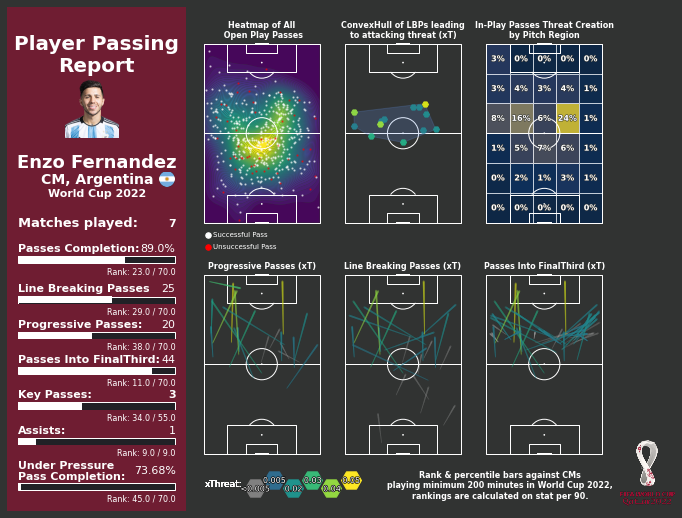

In [545]:
# %% Create player report

## Set up figure, grid and text/colour effects
fig = plt.figure(constrained_layout=False, figsize = (12.44, 7))
fig.set_facecolor('#313332')
gs = fig.add_gridspec(2, 4, left=0.21, right=0.98, bottom = 0.1, top = 0.94, wspace=0.05, hspace=0.2, width_ratios=[1,1,1,2], height_ratios = [2,2])
pitch1 = fig.add_subplot(gs[0,0])
pitch2 = fig.add_subplot(gs[0,1])
pitch3 = fig.add_subplot(gs[0,2])
pitch4 = fig.add_subplot(gs[1,0])
pitch5 = fig.add_subplot(gs[1,1])
pitch6 = fig.add_subplot(gs[1,2])

# Create side panel
title_ax = fig.add_axes([0, 0, 0.2, 1])
title_ax.set_facecolor('#6f1d32')
title_ax.axes.xaxis.set_visible(False)
title_ax.axes.yaxis.set_visible(False)
for spine in title_ax.spines.values():
    spine.set_visible(False)
    
# Define full pitch
full_pitch = VerticalPitch(pitch_color='#313332', pitch_type='uefa', line_color='w', linewidth=1, stripe=False)
for pitch_ax in [pitch1, pitch2, pitch3, pitch4, pitch5, pitch6]:
    full_pitch.draw(ax=pitch_ax)

# Path effects
path_eff = [path_effects.Stroke(linewidth=1, foreground='#313332'), path_effects.Normal()]

# Manual implentation of colourmap
pass_cmap = cm.get_cmap('viridis')
pass_cmap = pass_cmap(np.linspace(0.35,1,256))

## Titles and logo

# Main titles
text_start_y = 0.78
fig.text(0.1, 0.905, "Player Passing\nReport", fontsize=20, fontweight = "bold", color='w', ha = "center", va = "center")
fig.text(0.1, text_start_y-0.1,  Enzo_per_90.loc[18, 'player_name'], fontsize=18, fontweight = "bold", color='w', ha = "center")
fig.text(0.1, text_start_y-0.13,  Enzo_per_90.loc[18, 'most_common_role'] + ", " + Enzo_per_90.loc[18, 'team_name'] , fontsize=14, fontweight = "bold", color='w', ha = "center")
fig.text(0.1, text_start_y-0.157, 'World Cup 2022', fontsize=11, fontweight = "bold", color='w', ha = "center")

# Logo
r = "WC2022/world-cup-2022-logo-1.png."
img = Image.open(r)

a = "WC2022/73453.png"
Enzo = Image.open(a)

e = "WC2022/flag-round-250.png"
ARG = Image.open(e)
# add image
ax_image = add_image(
    img, fig, left=0.65, bottom=0.01, width=0.13, height=0.13
) 

# add image
ax_image = add_image(
    Enzo, fig, left=0.03, bottom=0.74, width=0.13, height=0.13
) 

ax_image = add_image(
    ARG, fig, left=0.163, bottom=0.642, width=0.03, height=0.03
) 

# Top level stats
stat_start_y = 0.65
fig.text(0.012, stat_start_y-0.08, "Matches played:", fontsize=13, fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.08, Enzo_per_90.loc[18, 'games_played'], fontsize=11, fontweight = "bold", color='w', va = "center", ha = "right")

fig.text(0.012, stat_start_y-0.13, "Passes Completion:", fontsize=11, fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.13, str(player_passes_CM.loc[86, 'passes_completion_%'])+'%', fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar1 = fig.add_axes([0.0125, stat_start_y-0.16, 0.183, 0.016])
bar1.barh(0.2, 100, height = 1, edgecolor = 'w', color = '#212126')
bar1.barh(0.2, int(player_passes_CM.loc[86, 'pass_completion_%_percentile']) , height = 1, edgecolor = None, color = 'w')
bar1.axis("off")
fig.text(0.188, stat_start_y-0.175, 'Rank: '+str(player_passes_CM.loc[86, 'player_Rank_%'])+' / '+str(player_passes_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")



fig.text(0.012, stat_start_y-0.21, "Line Breaking Passes", fontsize=11, fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.21, int(player_lb_CM.loc[82, 'line_breaking_passes']), fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar2 = fig.add_axes([0.0125, stat_start_y-0.24, 0.183, 0.016])
bar2.barh(0.2, 100, height = 1, edgecolor = 'w', color = '#212126')
bar2.barh(0.3, int(player_lb_CM.loc[82, 'line_breaking_per_90_percentile']) , height = 1, edgecolor = None, color = 'w')
bar2.axis("off")
fig.text(0.188, stat_start_y-0.255, 'Rank: '+str(player_lb_CM.loc[82, 'player_Rank_%'])+' / '+str(player_lb_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")

fig.text(0.012, stat_start_y-0.28, "Progressive Passes:", fontsize=11, fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.28, int(player_progressive_CM.loc[83, 'Progressive_passes']), fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar3 = fig.add_axes([0.0125, stat_start_y-0.31, 0.183, 0.016])
bar3.barh(0.5, 100, height = 1, edgecolor = 'w', color = '#212126')
bar3.barh(0.5, player_progressive_CM.loc[83, 'progressive_passes_per_90_percentile'] , height = 1, edgecolor = None, color = 'w')
bar3.axis("off")
fig.text(0.188, stat_start_y-0.325, 'Rank: '+str(player_progressive_CM.loc[83, 'player_Rank_%'])+' / '+str(player_progressive_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")


fig.text(0.012, stat_start_y-0.35, "Passes Into FinalThird:", fontsize=11,  fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.35, int(player_IntoFinalThird_CM.loc[82, 'IntoFinalThird']), fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar4 = fig.add_axes([0.0125, stat_start_y-0.38, 0.183, 0.016])
bar4.barh(0.5, 100, height = 1, edgecolor = 'w', color = '#212126')
bar4.barh(0.5, player_IntoFinalThird_CM.loc[82, 'IntoFinalThird_CM_per_90_percentile'] , height = 1, edgecolor = None, color = 'w')
bar4.axis("off")
fig.text(0.188, stat_start_y-0.395, 'Rank: '+str(player_IntoFinalThird_CM.loc[82, 'player_Rank_%'])+' / '+str(player_IntoFinalThird_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")


fig.text(0.012, stat_start_y-0.42, "Key Passes:", fontsize=11, fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.42, int(player_KP_CM.loc[51, 'Key_passes']), fontsize=11, fontweight = "bold", color='w', va = "center", ha = "right")
bar5 = fig.add_axes([0.0125, stat_start_y-0.45, 0.183, 0.016])
bar5.barh(0.5, 100, height = 1, edgecolor = 'w', color = '#212126')
bar5.barh(0.5, player_KP_CM.loc[51, 'KP_per_90s_percentile'] , height = 1, edgecolor = None, color = 'w')
bar5.axis("off")
fig.text(0.188, stat_start_y-0.465, 'Rank: '+str(player_KP_CM.loc[51, 'player_Rank_%'])+' / '+str(player_KP_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")


fig.text(0.012, stat_start_y-0.49, "Assists:", fontsize=11,  fontweight = "bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.49, int(player_Assists_CM.loc[20, 'Assists']), fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar6 = fig.add_axes([0.0125, stat_start_y-0.52, 0.183, 0.016])
bar6.barh(0.5, 100, height = 1, edgecolor = 'w', color = '#212126')
bar6.barh(0.5, player_Assists_CM.loc[20, 'Assists_per_90s_percentile'] , height = 1, edgecolor = None, color = 'w')
bar6.axis("off")
fig.text(0.188, stat_start_y-0.535, 'Rank: '+str(player_Assists_CM.loc[20, 'player_Rank_%'])+' / '+str(player_Assists_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")



fig.text(0.012, stat_start_y-0.571, "Under Pressure\nPass Completion:", fontsize=11, fontweight="bold", color='w', va = "center")
fig.text(0.188, stat_start_y-0.571, str(player_under_pressure_CM.loc[19, 'under_pressure_completion_%'])+'%', fontsize=11, fontweight="regular", color='w', va = "center", ha = "right")
bar7 = fig.add_axes([0.0125, stat_start_y-0.61, 0.183, 0.016])
bar7.barh(0.5, 100, height = 1, edgecolor = 'w', color = '#212126')
bar7.barh(0.5, player_under_pressure_CM.loc[19, 'percentile_under_pressure_completion_%'] , height = 1, edgecolor = None, color = 'w')
bar7.axis("off")
fig.text(0.188, stat_start_y-0.625, 'Rank: '+str(player_under_pressure_CM.loc[19, 'player_Rank_%'])+' / '+str(player_under_pressure_CM['player_Rank_%'].max()), fontsize=8, color='w', ha = "right", va = "center")



pitch4.set_title("Progressive Passes (xT)", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")
for _, single_pass in Player_progressive_passes_xT_Enzo.iterrows():
    pass_xt = single_pass['xT']
    if pass_xt < 0.005:
        line_colour = 'w'
        line_alpha = 0.03
        zorder = 1
    else:
        line_colour = pass_cmap[int(255*min(pass_xt/0.05, 1))]
        line_alpha = 0.2
        zorder = 2
    full_pitch.lines(single_pass['start_x'], single_pass['start_y'], single_pass['end_x'], single_pass['end_y'], lw = 2, comet=True, capstyle='round',
                alpha = line_alpha, color = line_colour, zorder=zorder, ax=pitch4)
    
    

pitch5.set_title("Line Breaking Passes (xT)", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")
for _, single_pass in Player_line_breaking_passes_xT_Enzo.iterrows():
    pass_xt = single_pass['xT']
    if pass_xt < 0.005:
        line_colour = 'w'
        line_alpha = 0.03
        zorder = 1
    else:
        line_colour = pass_cmap[int(255*min(pass_xt/0.05, 1))]
        line_alpha = 0.2
        zorder = 2
    full_pitch.lines(single_pass['start_x'], single_pass['start_y'], single_pass['end_x'], single_pass['end_y'], lw = 2, comet=True, capstyle='round',
                alpha = line_alpha, color = line_colour, zorder=zorder, ax=pitch5)
    
    
    
pitch6.set_title("Passes Into FinalThird (xT)", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")
for _, single_pass in Player_IntoFinalThird_passes_xT_Enzo.iterrows():
    pass_xt = single_pass['xT']
    if pass_xt < 0.005:
        line_colour = 'w'
        line_alpha = 0.03
        zorder = 1
    else:
        line_colour = pass_cmap[int(255*min(pass_xt/0.05, 1))]
        line_alpha = 0.2
        zorder = 2
    full_pitch.lines(single_pass['start_x'], single_pass['start_y'], single_pass['end_x'], single_pass['end_y'], lw = 2, comet=True, capstyle='round',
                alpha = line_alpha, color = line_colour, zorder=zorder, ax=pitch6)

pitch3.set_title("In-Play Passes Threat Creation\nby Pitch Region", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")
player_passes_Enzo['xT'] = player_passes_Enzo['xT'].apply(lambda x: x if x>0 else 0)

bin_statistic_2 = full_pitch.bin_statistic(player_passes_Enzo['start_x'], player_passes_Enzo['start_y'],
                                    statistic='sum', bins=(6, 5), normalize=True, values = player_passes_Enzo['xT'])
full_pitch.heatmap(bin_statistic_2, pitch3, cmap='cividis', edgecolor='w', lw=0.5, zorder=0, alpha=0.7)
labels = full_pitch.label_heatmap(bin_statistic_2, color='w', fontsize=8, fontweight = "bold",
                             ax=pitch3, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)


# Add legends
legend_ax = fig.add_axes([0.22, 0.023, 0.18, 0.06])
legend_ax.axis("off")
plt.xlim([0, 8])
plt.ylim([0, 1])
hex_count = 6
path_eff = [path_effects.Stroke(linewidth=1.25, foreground='k'), path_effects.Normal()]

for idx in np.arange(0,hex_count):
    
    if idx%2 == 0:
        ypos = 0.36
    else:
        ypos= 0.64
    xpos = idx/1.05 + 2.5
    
    if idx == 0:
        xt = '<0.005'
        color = 'grey'
    elif idx == 1:
        xt = round(0.005 + (0.05-0.005) * ((idx-1)/(hex_count-2)),3)
        color = pass_cmap[int(255*(idx-1)/(hex_count-2))]
    else:
        xt = round(0.005 + (0.05-0.005) * ((idx-1)/(hex_count-2)),2)
        color = pass_cmap[int(255*(idx-1)/(hex_count-2))]
    
    legend_ax.scatter(xpos, ypos, marker='H', s=400, color=color, edgecolors=None)
    legend_ax.text(xpos+0.03, ypos-0.02, xt, color='w', fontsize = 8, ha = "center", va = "center", path_effects = path_eff)
    legend_ax.text(0, 0.5, "xThreat:", color='w', fontsize = 9, ha = "left", va = "center", fontweight="regular")



# Title 
pitch1.set_title("Heatmap of All\n Open Play Passes", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")

# Heatmap
full_pitch.kdeplot(player_attempts_Enzo['start_x'], player_attempts_Enzo['start_y'], fill=True, levels=80, shade_lowest=True, cmap='viridis', cut=8, alpha=1, antialiased=True, zorder=0, ax=pitch1)  

# Pass scatter
for _,touch in player_attempts_Enzo.iterrows():
    if touch['result_name'] == 'success':
        c = 'w'
    else:
        c = 'r'
    full_pitch.scatter(touch['start_x'], touch['start_y'], color = c, marker='h', alpha = 0.5, s = 2, zorder=1, ax=pitch1)

# Add legend
legend_ax = fig.add_axes([0.22, 0.5, 0.1, 0.06])
legend_ax.axis("off")

legend_ax.scatter(0.04,0.8, s=30, color = 'w')
legend_ax.text(0.1,0.89, "Successful Pass", va = "top", color='w', fontsize = 7)
legend_ax.scatter(0.04,0.4, s=30, color = 'r')
legend_ax.text(0.1,0.49, "Unsuccessful Pass", va = "top", color='w', fontsize = 7)

legend_ax.set_xlim(0,1)
legend_ax.set_ylim(0,1)


pitch2.set_title("ConvexHull of LBPs leading\nto attacking threat (xT)", pad = -1, fontsize = 8, color = 'w', fontweight = "bold")
for _, passat in Enzo_lb_intoFinalThird_passes.iterrows():
    pass_xt = passat['xT']
    if pass_xt < 0.005:
        line_colour = 'w'
        line_alpha = 0.03
        zorder = 1
    else:
        line_colour = pass_cmap[int(255*min(pass_xt/0.05, 1))]
        line_alpha = 1
        zorder = 2
    full_pitch.scatter(passat['start_x'], passat['start_y'], marker = 'H',
                alpha = line_alpha, color = line_colour, zorder=zorder, ax=pitch2)
     
hull = full_pitch.convexhull(Enzo_lb_intoFinalThird_passes.start_x, Enzo_lb_intoFinalThird_passes.start_y)
poly = full_pitch.polygon(hull, ax=pitch2, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.2)

    


fig.text(0.55, 0.08, f"Rank & percentile bars against CMs\nplaying minimum 200 minutes in World Cup 2022,\nrankings are calculated on stat per 90.", fontsize=8, fontweight="bold", color='w', va = "top", ha = "center")

#fig.savefig('Enzo Fernandez Passing Ability Report.jpeg', format='jpeg', dpi=600 )